# Lecture 7 - Quantile Regression

## Today's Learning Goals

By the end of this lecture, you should be able to:

- Review what a quantile is.
- Compare the error functions of Ordinary Least-squares (OLS) regression versus Quantile regression.
- Recognize the impacts of parametric and distributional assumptions in Quantile regression.
- Perform non-parametric Quantile regression.
- Perform parametric Quantile regression.

## Loading Libraries and Scripts

In [1]:
options(repr.matrix.max.rows = 6)
source("../scripts/support_functions.R")
library(tidyverse)
library(quantreg)
library(Lahman)
library(broom)
library(modelr)
library(glmbb)
library(cowplot)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: SparseM




Attaching package: ‘modelr’




The following object is masked from ‘package:broom’:

    bootstrap





Attaching package: ‘cowplot’




The following object is masked from ‘package:lubridate’:

    stamp




**We will close our regression mindmap in MDS** with an approach on **conditioned quantiles**: Quantile regression. Note we will check two approaches: parametric (for inference and prediction) and non-parametric (for prediction).

````{div} full-width
```{figure} ../img/reg-mindmap-7.png
:height: 600px
:name: reg-mindmap-7
Expanded regression modelling mind map (click on the image to zoom in).
```
````

## 1. The Quantiles

Let us set up an initial example to recap **what a quantile is**. Suppose we measure the height of $n = 1000$ randomly sampled UBC students. Here is the sample average in centimetres:

In [2]:
set.seed(123)
sample_heights <- draw_sample(1000)
sample_mean <- round(mean(sample_heights), 2)
sample_mean

[1] 175.11

```{exercise}
:label: lecture7-q1

**By only using that single sample average**, try to answer the following:

- How much do you know about the distribution of these `heights`?
- Is it a **symmetric distribution**?
- Is it a **heavy-tailed-distribution**?
- What is the **variance** of this distribution?
```

This is the reason why a boxplot is more meaningful than just jittered points.

Hence, let us get more information from the sample via `summary()` and `var()`.

In [3]:
summary(sample_heights)
paste("variance: ", round(var(sample_heights),2))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  155.3   170.6   175.1   175.1   179.7   197.7 

[1] "variance:  48.19"

```{exercise}
:label: lecture7-q2

What about now? Do we have a better idea about the distribution?

**A.** Yes, having different quantiles gives us a better idea about the distribution of heights.

**B.** Not, at all!
```

We can also make a quick histogram (with the sample mean as a vertical red line) or boxplot to confirm our previous statements.

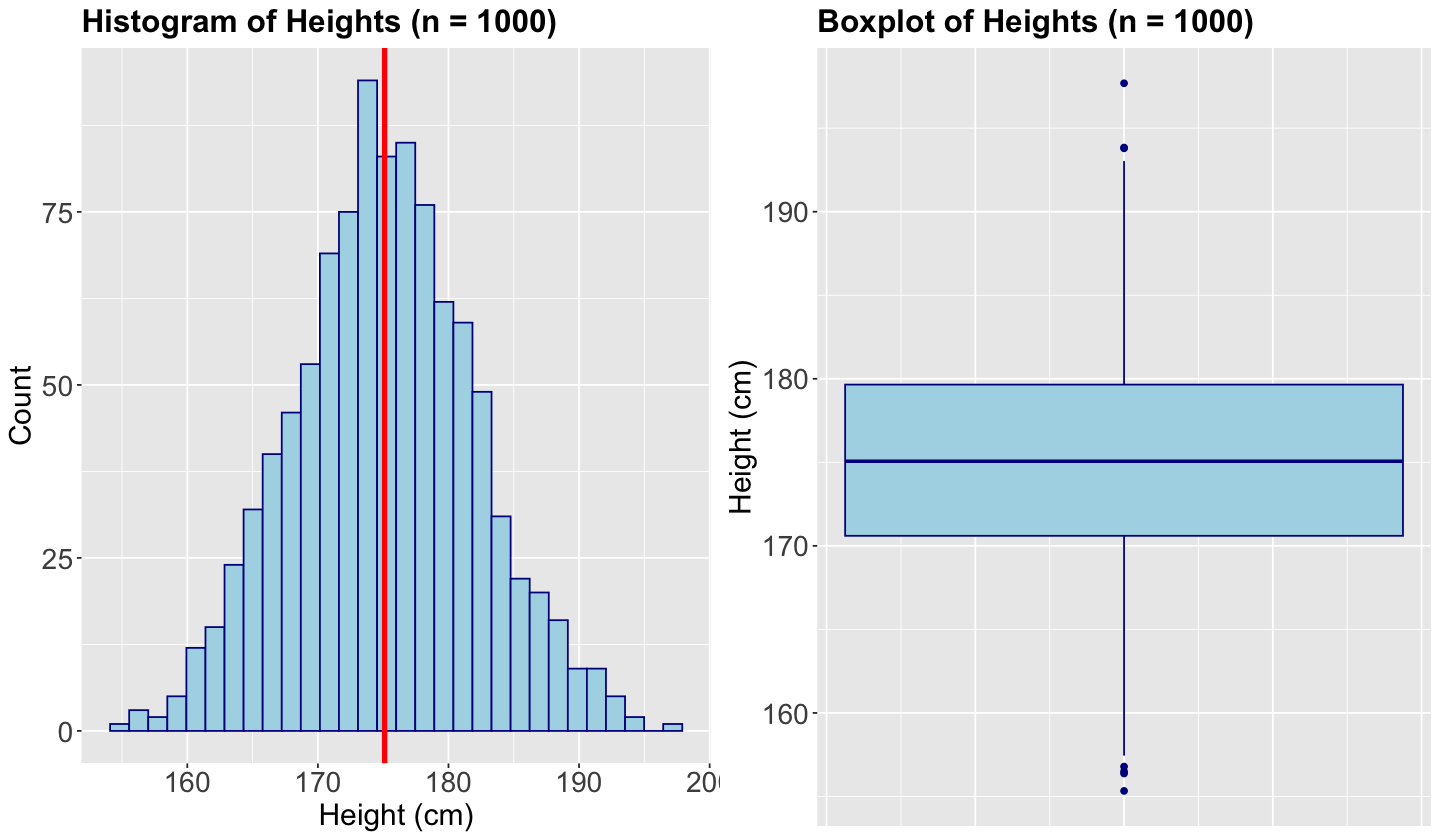

In [4]:
options(repr.plot.height = 7, repr.plot.width = 12)

sample_heights <- as.data.frame(sample_heights)

hist_heights <- ggplot(sample_heights, aes(x = sample_heights)) +
  geom_histogram(color = "darkblue", fill = "lightblue", bins = 30) +
  theme(
    plot.title = element_text(size = 19, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 18)
  ) +
  labs(x = "Height (cm)", y = "Count") +
  ggtitle("Histogram of Heights (n = 1000)") +
  geom_vline(xintercept = sample_mean, color = "red", linewidth = 1.5)

boxplot_heights <- ggplot(sample_heights, aes(y = sample_heights)) +
  geom_boxplot(color = "darkblue", fill = "lightblue") +
  theme(
    plot.title = element_text(size = 19, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 18),
    axis.ticks.x = element_blank(),
    axis.text.x = element_blank()
  ) +
  labs(y = "Height (cm)") +
  ggtitle("Boxplot of Heights (n = 1000)")

plot_grid(hist_heights, boxplot_heights)

### 1.1. Let us recall what a quantile is!

Suppose we have a random variable $X\sim F_X(\cdot)$, i.e., $X$ has a cumulative distribution function (CDF) $F_X(\cdot)$. Then, the $\tau$-quantile ($0\leq \tau \leq 1$), is given by $Q(\tau)$ such that 

$$F_X[Q(\tau)]= P[X\leq Q(\tau)] = \tau.$$

In plain words, the quantile $Q(\tau)$ is that observed value of $X$ for which **$\tau \times 100\%$ of the population's data is below** (or **the area under the curve on the left-hand side of a given $x$**, if we check the horizontal axis on the probability density function).

As an example, we can check the case of the 0.75-quantile in the **Standard Normal distribution** using its probability density function (PDF).

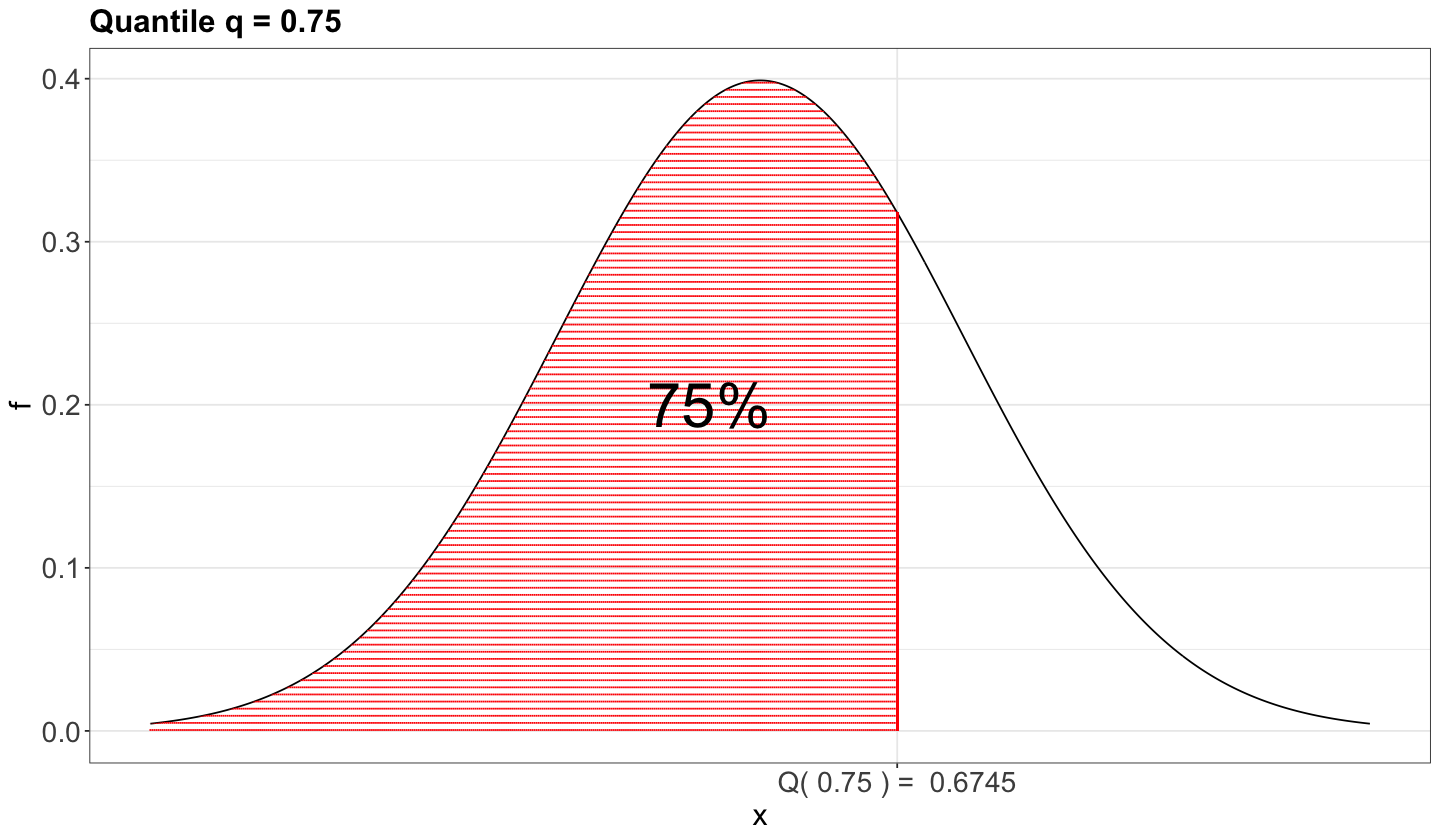

In [5]:
q <- 0.75 # Quantile value between 0 and 1
sim_data <- tibble(x = seq(-3, 3, 0.01), f = dnorm(x))
quantile_plot <- sim_data |>
  ggplot() +
  geom_line(aes(x, f)) +
  geom_segment(aes(x = x, y = 0, xend = x, yend = dnorm(x)),
    color = "red",
    linetype = "dotted",
    data = sim_data |> filter(x <= qnorm(q))
  ) +
  geom_segment(aes(
    x = qnorm(q), y = 0, xend = qnorm(q),
    yend = dnorm(qnorm(q))
  ), color = "red") +
  scale_x_continuous(breaks = qnorm(q), labels = paste(
    "Q(", q, ") = ",
    round(qnorm(q), 4)
  )) +
  ggtitle(paste0("Quantile q = ", q)) +
  theme_bw() +
  annotate("text",
    x = -.25, y = .2, label = paste0(q * 100, "%"),
    size = 1.5 * sqrt(100 * q)
  ) +
  theme(
    plot.title = element_text(size = 19, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 18)
  )

suppressWarnings(suppressMessages(print(quantile_plot)))

Moreover, we can also show it using the CDF where the cumulative probabilities are on the $y$-axis.

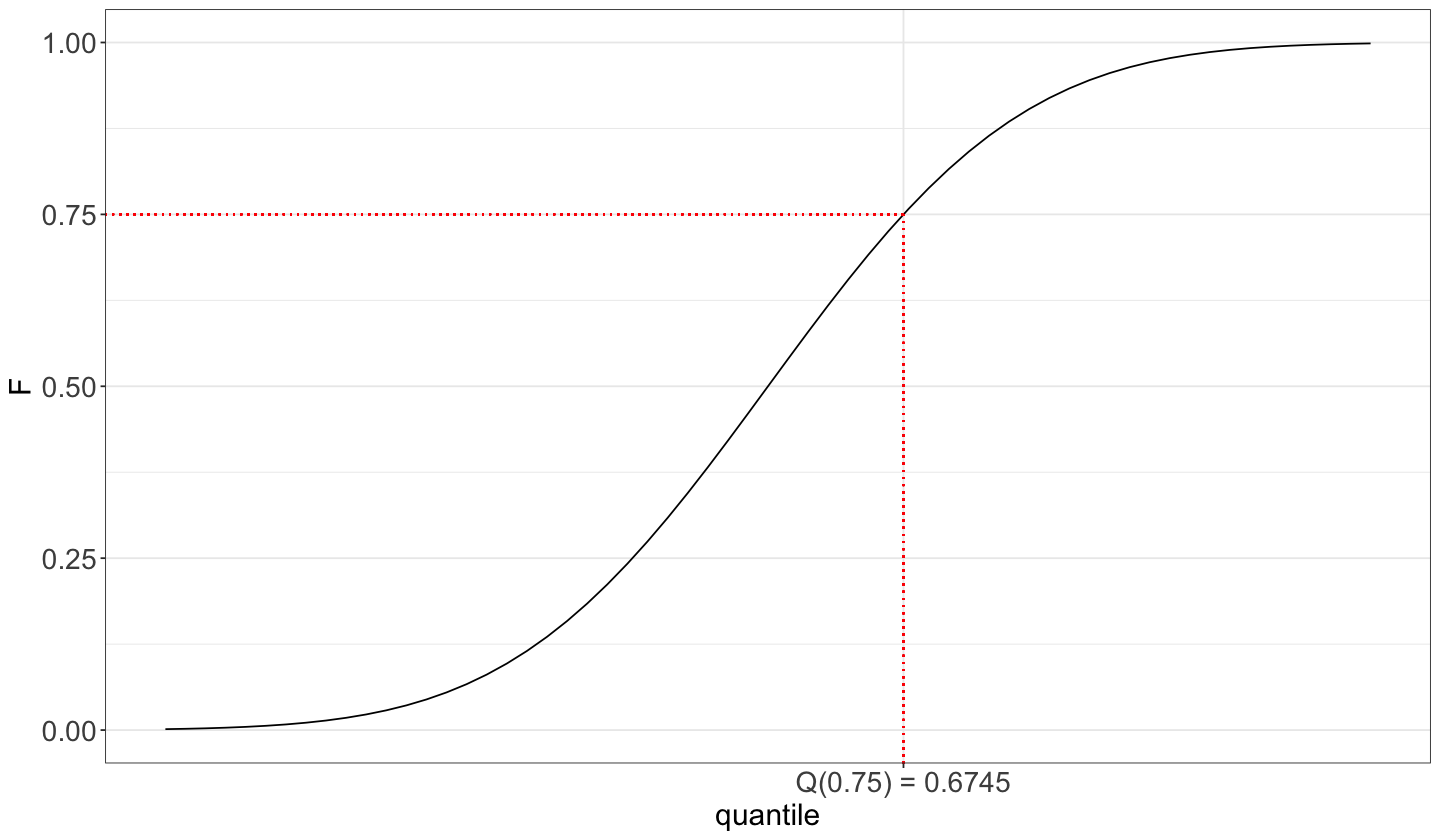

In [6]:
CDF <- example_quantile_cdf(q = 0.75) +
  theme_bw() +
  theme(
    plot.title = element_text(size = 19, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 18)
  )

suppressWarnings(suppressMessages(print(CDF)))

### 1.2. Motivation for Quantile Regression

In the OLS regression model, we were focused on the conditional mean on the regressors:

$$
\mathbb{E}(Y_i \mid X_{i,j} = x_{i,j}) = \beta_0 + \beta_1 x_{i,1} + \ldots + \beta_k x_{i,k} \; \; \; \; \text{since} \; \; \; \; \mathbb{E}(\varepsilon_i) = 0.
$$

Moreover, we already discussed that (from the statistical point of view) regression models follow a stochastic relation.

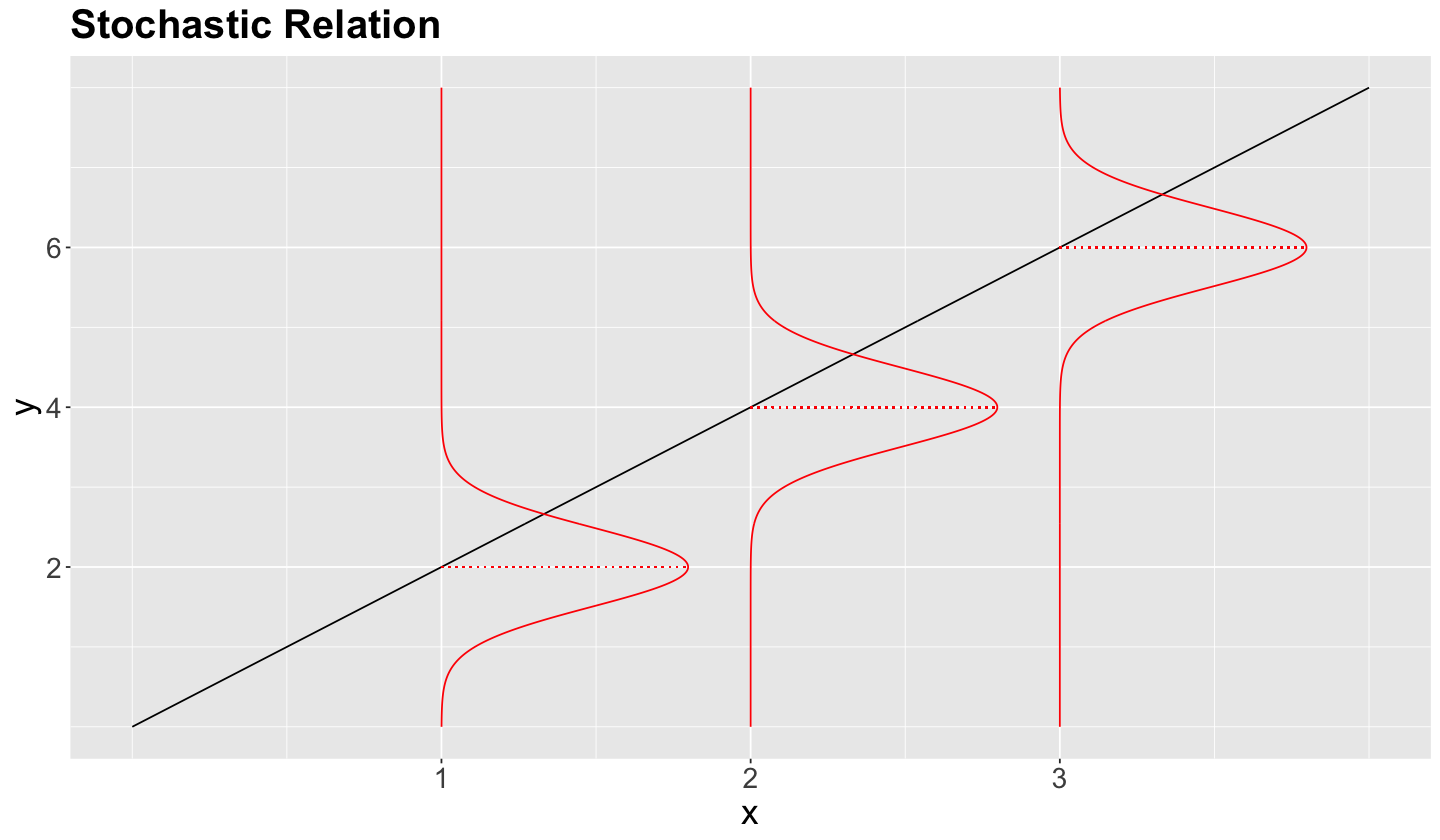

In [7]:
suppressWarnings(suppressMessages(print(example_stochastic_relation())))

Nonetheless, **is it possible to go beyond the conditioned mean?**

Given the stochastic nature of the relation between the response and explanatory variables, we have **a whole conditional distribution** of the response $Y_i$, given the $k$ explanatory variables $X_{i,j}$. 

```{important}
This whole conditional distribution **allows us to regress our response with more than just the mean, such as the median or any other quantiles!**

The below plot shows the stochastic nature of the conditional distribution for the $0.95$-quantile.
```

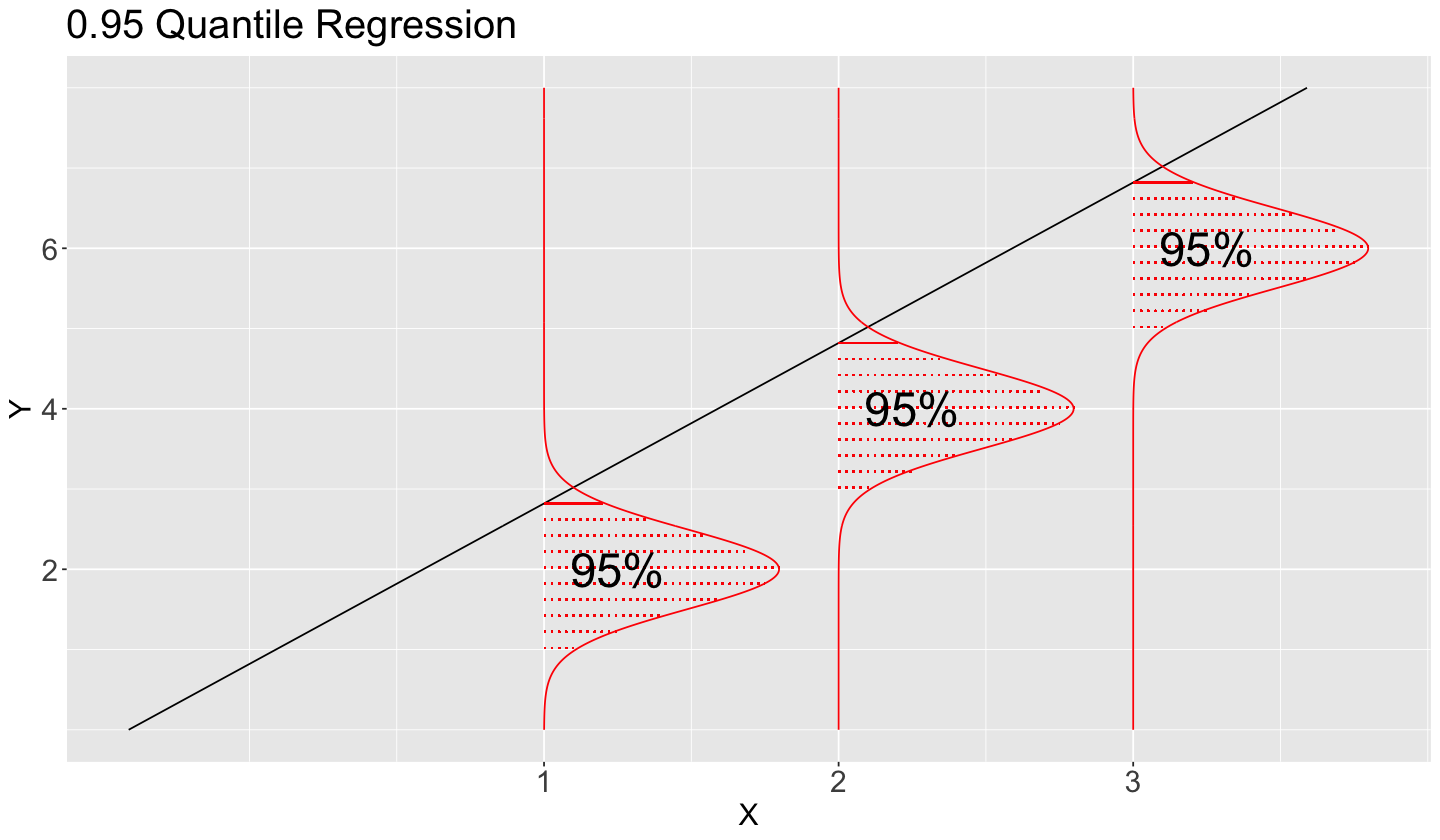

In [8]:
suppressWarnings(suppressMessages(print(example_quantile_regression())))

Having said all this, let us pave to this new regression framework called **Quantile regression**.

## 2. Applications of Quantile Regression

In many practical cases, we have **inferential questions** that are related to quantiles and not the mean.

We might want to see if, at different levels, the response is affected differently by the explanatory variables:

> *How do driver's years of experience affect buses' travel time when considering the 25% fastest travels, 50% fastest travels, and 90% fastest travels?*

> *How does the alcohol price affect the weekly consumption of light drinkers, moderate drinkers, and heavy drinkers at given cut-off values of alcohol consumption?*

Furthermore, we might also be interested in a **probabilistic prediction**:

> *During December in Vancouver, with a 95% chance, what is the maximum snowfall threshold?*

```{important}
This prediction **will not** be a confidence interval since we are talking about probabilities (i.e., chances). Therefore, we can use "probability" instead of "confidence." Moreover, we would obtain **prediction bands** (to be explained later on in this lecture).
```

Note we can translate these inquiries with $\tau$-quantiles ($\tau \in [0, 1]$) along with the regressor $X$ and response $Y$:

> *How do **driver's years of experience** ($X$) affect buses' **travel time** (Y) when considering the 25% fastest travels ($\tau = 0.25$), 50% fastest travels ($\tau = 0.5$), and 90% fastest travels ($\tau = 0.9$)?*

> *How does the **alcohol price** ($X$) affect the **weekly consumption** ($Y$) of light drinkers ($\tau = 0.25$), moderate drinkers ($\tau = 0.5$), and heavy drinkers ($\tau = 0.9$) in given cut-off values in weekly alcohol consumption?*

> *During **December** ($X$) in Vancouver, with a 95% ($\tau = 0.95$) chance, what is the **maximum snowfall** $(Y)$ threshold?*

### 2.1. The Teams Dataset

For today's lecture, we will use the `Teams` dataset from the `Lahman` package. It has $n = 3045$ observations of 48 variables related to yearly statistics and standings for teams (**one row per team**) from different American baseball leagues.

```{note}
We can find the dataset's website [here](http://seanlahman.com/):

> The updated version of the database contains complete batting and pitching statistics from 1871 to 2023, plus fielding statistics, standings, team stats, managerial records, post-season data, and more. For more details on the latest release, please read the documentation.
```

We will use the following columns:

- `runs`: Runs scored, a **count**-type variable.
- `hits`: Hits by batters, a **count**-type variable.

In [9]:
teams <- Teams |>
  select(runs = R, hits = H)
teams

runs,hits
<int>,<int>
401,426
302,323
249,328
⋮,⋮
674,1271
719,1376
700,1401


```{admonition} Main statistical inquiries
Let us suppose you are an American baseball enthusiast. Thus, you are interested in determining the following using this recorded data:

1. Previous research has shown you that a large number of runs is associated with a large number of hits. Having said that, **for those teams at the upper 75% threshold in runs**, is this association significant? If so, by how much?
2. **For any given team that scores 1000 hits in a future tournament**, how many runs can this team score with a 50% chance (centred around this future tournament's median runs)?
```

### 2.2. Exploratory Data Analysis

Let us create a scatterplot of `hits` (our regressor) versus `runs` (our response), **even though these variables are not continuous**.

```{attention}
The upcoming Quantile regression approaches are meant for continuous responses **in their most basic modelling frameworks**. Nevertheless, by looking at the below scatterplot, `runs` behaviour resembles a continuous variable given its clear scatteredness. This class of behaviour is case-specific, and some other datasets whose response is a count would need an extra adjustment if it is much less scattered (see the [**optional material**](quantile-regression-discrete-data) in these notes).
```

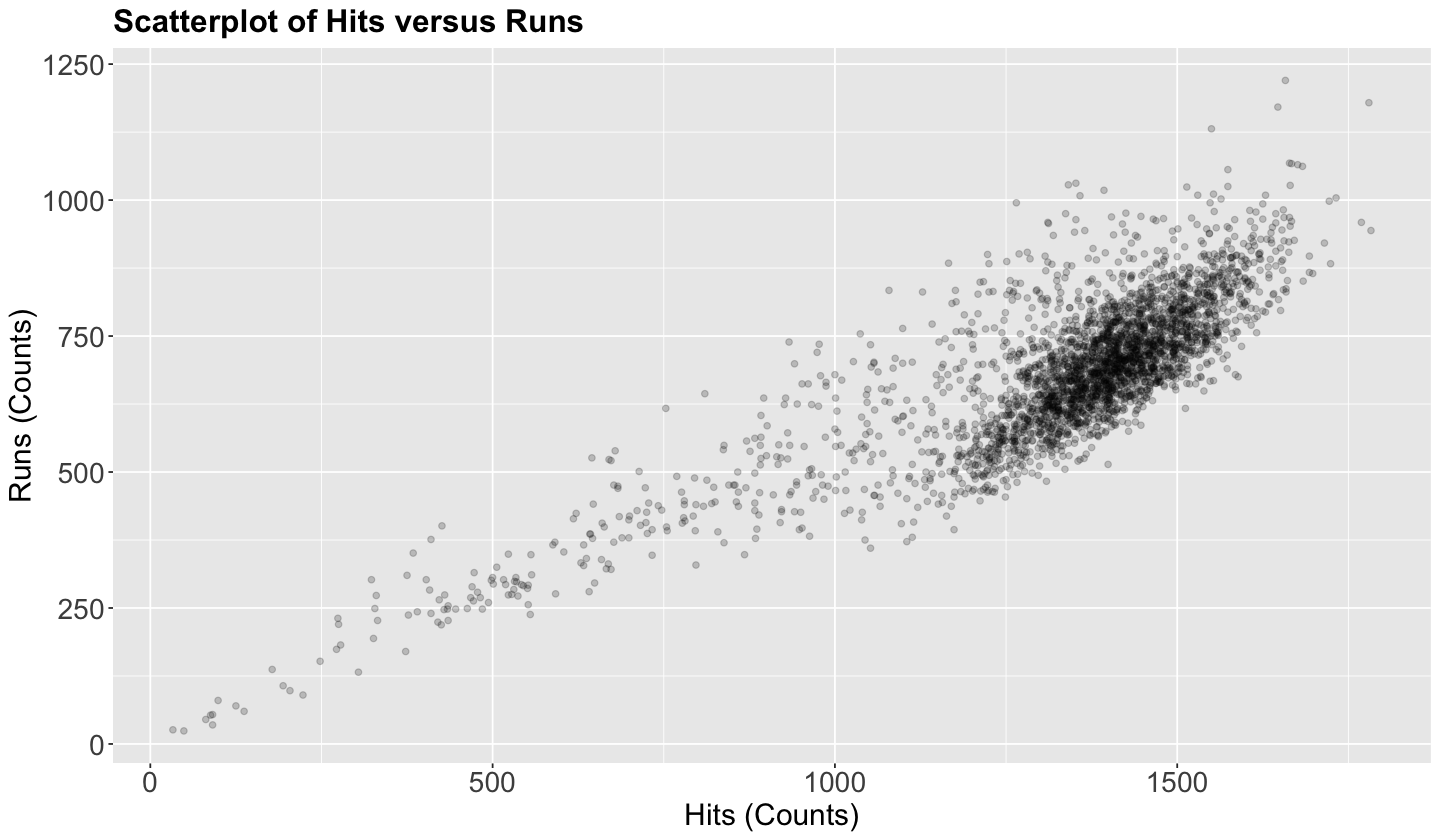

In [10]:
teams_scatterplot <- ggplot(teams, aes(hits, runs)) +
  geom_point(alpha = 0.2, colour = "black") +
  theme(
    plot.title = element_text(size = 19, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 18)
  ) +
  xlab("Hits (Counts)") +
  ylab("Runs (Counts)") +
  ggtitle("Scatterplot of Hits versus Runs")

teams_scatterplot

This plot shows a clear positive relationship between `hits` and `runs`. Nevertheless, we need to go further and fit our corresponding model to address our inquiries.

## 3. Parametric Quantile Regression

We can address inquiries (1) and (2) via parametric Quantile regression. But before digging into this model, it is necessary to recall some fundamentals from OLS.

In OLS, we use a linear combination on the right-hand sice to explain the conditional mean

$$
\mathbb{E}(Y_i \mid X_{i,j} = x_{i,j}) = \beta_0 + \beta_1 x_{i,1} + \ldots + \beta_k x_{i,k};
$$

and then find $\hat{\beta}_0, \hat{\beta}_1, \dots, \hat{\beta}_k$ that **minimize the squared error (loss function) in our training set of size $n$**

$$
\sum_{i = 1}^n (y_i - \beta_0 - \beta_1 x_{i,1} - \ldots - \beta_k x_{i,k})^2.
$$

### 3.1. General Modelling Framework

Suppose we have a random sample (or **training data**) of size $n$ with responses $Y_1, Y_2, \dots, Y_n$ where $i = 1, 2, \dots, n$. Each $i$th response is subject to $k$ regressors $X_{i, 1}, X_{i, 2}, \dots, X_{i, k}$. Furthermore, we are interested in modelling the response's $\tau$-quantile, where $\tau \in [0, 1]$, conditioned on these $k$ regressors in a linear combination with an intercept $\beta_0(\tau)$ and $k$ regression coefficients $\beta_1(\tau), \beta_2(\tau), \dots, \beta_k(\tau)$:

```{math}
:label: quantile-regression-eq-1
Y_i = \underbrace{\beta_0(\tau) + \beta_1(\tau) X_{i,1} + \beta_2(\tau) X_{i,2} + \ldots + \beta_k(\tau) X_{i,k}}_{\text{Systematic Component}} + \underbrace{\varepsilon_i(\tau).}_{\text{Random Component}}
```

```{important}
In Equation {eq}`quantile-regression-eq-1`, $\beta_j(\tau)$ (for $j = 0, 1, 2, \dots, k$) means that the regression term depends on the quantile $\tau$, which is the desired quantile. In other words, for each quantile, we (**might if our inquiry dictates so!**) have a different regression function on the right-hand side of our modelling equation.

Finally, we still have a **random component** for the $i$th observation (as in OLS) represented as $\varepsilon_i(\tau)$, which also depends on the quantile $\tau$. Nonetheless, this random component is **distribution-agnostic**.
```

```{admonition} Definition of a Distribution-agnostic Random Component 
:class: tip
In Regression Analysis, a model with a distribution-agnostic random component does not assume any particular probability distribution a priori. Still, we assume an unspecified probability distribution on this component.
```

Let us make some mathematical rearrangements in Equation {eq}`quantile-regression-eq-1` and put the **random component** on the left-hand side:

```{math}
:label: quantile-regression-eq-2
\begin{gather*}
\varepsilon_i(\tau) = Y_i - \underbrace{\left[ \beta_0(\tau) + \beta_1(\tau) X_{i,1} + \beta_2(\tau) X_{i,2} + \ldots + \beta_k(\tau) X_{i,k} \right]}_{\text{Systematic Component}}.
\end{gather*}
```

Moreover, taking Equation {eq}`quantile-regression-eq-2` as a reference, Quantile regression **must ensure** the following **global condition**:

$$
P \left[ \varepsilon_i(\tau) < 0 \mid  X_{i, 1}, X_{i, 2}, \dots, X_{i, k} \right] = \tau.
$$

The above **probability expression** requires that the conditioned probability (**on the regressors!**) of any overprediction, i.e. when the difference between $Y_i$ and the **systematic component** on the right-hand side of the Equation {eq}`quantile-regression-eq-2` is negative, must be equal to $\tau$. 

**In a more practical setting**, suppose you use the `teams` dataset to fit a Quantile regression of `runs` ($Y$) versus `hits` ($X_1$) on the response's quantile $\tau = 0.75$. Then, your regression equation for the $i$th observation becomes:

$$
Y_i = \underbrace{\beta_0(\tau = 0.75) + \beta_1(\tau = 0.75) X_{i,1}}_{\text{Systematic Component}} + \underbrace{\varepsilon_i(\tau = 0.75)}_{\text{Random Component}},
$$

which yields

```{math}
:label: quantile-regression-eq-3
\begin{gather*}
\varepsilon_i(\tau = 0.75) = Y_i - \underbrace{\left[ \beta_0(\tau = 0.75) + \beta_1(\tau = 0.75) X_{i,1} \right]}_{\text{Systematic Component}}.
\end{gather*}
```

with

$$
P \left[ \varepsilon_i(\tau = 0.75) < 0 \mid  X_{i, 1} \right] = \tau = 0.75.
$$

Therefore, the **estimated Quantile regression line** with $\hat{\beta}_0(\tau = 0.75)$ and $\hat{\beta}_1(\tau = 0.75)$ must look like the red line of the subsequent plot where we plot the regressor `hits` versus the response `runs`. The **above probability statement** indicates in practice that **BELOW the estimated Quantile regression line** we will **approximately** have 75% of the observed points (i.e., a proportion of $0.75$). These 75% of points are those for which the difference between the observed response $Y_i$ and the **estimated systematic component of the Quantile regression** is negative **if we take Equation {eq}`quantile-regression-eq-3` into account**.

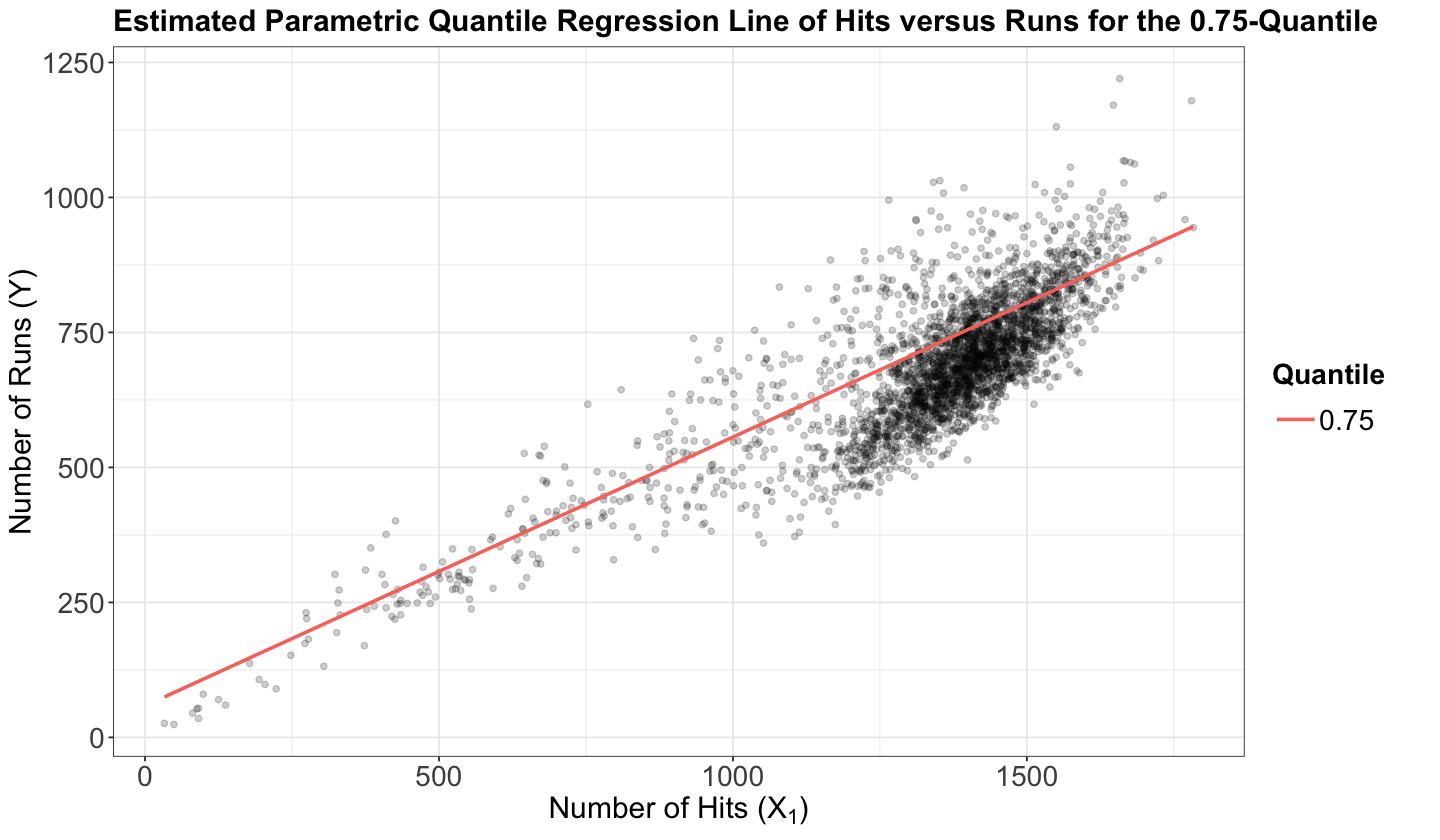

In [11]:
ggplot(teams, aes(hits, runs)) +
  geom_point(alpha = 0.2, colour = "black") +
  geom_quantile(
    quantiles = c(0.75), aes(colour = as.factor(after_stat(quantile))),
    formula = y ~ x, linewidth = 1
  ) +
  theme_bw() +
  labs(
    x = expression(paste("Number of Hits (", X[1], ")")),
    y = "Number of Runs (Y)"
  ) +
  theme(
    plot.title = element_text(size = 18, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 18),
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm")),
    legend.title = element_text(size = 17, face = "bold"),
    legend.key.size = unit(1, "cm")
  ) +
  guides(colour = guide_legend(title = "Quantile", reverse = TRUE)) +
  ggtitle("Estimated Parametric Quantile Regression Line of Hits versus Runs for the 0.75-Quantile")

Summarizing, a **parametric Quantile regression** will condition the $\tau$-quantile to $k$ regressors in a linear combination with an intercept $\beta_0(\tau)$ and $k$ regression coefficients:

```{math}
:label: conditioned-quantile
\begin{equation}
Q_i( \tau \mid X_{i,j} = x_{i,j}) = \beta_0(\tau) + \beta_1(\tau) x_{i,1} + \ldots + \beta_k(\tau) x_{i,k};
\end{equation}
```

and then find $\hat{\beta}_0(\tau), \hat{\beta}_1(\tau), \dots, \hat{\beta}_k(\tau)$ that **minimize the following error function (loss function)**

```{math}
:label: fidelity-function
\begin{equation}
\sum_{i} e_i[\tau - I(e_i < 0)] = \sum_{i: e_i \geq 0} \tau|e_i|+\sum_{i: e_i < 0}(1-\tau)|e_i|
\end{equation}
```

Note Equation {eq}`conditioned-quantile` for a determined $\tau$-quantile is **analogous to the conditional expected value that OLS aims to model such as**:

$$
\mathbb{E}(Y_i \mid X_{i,j} = x_{i,j}) = \beta_0 + \beta_1 x_{i,1} + \ldots + \beta_k x_{i,k}.
$$

```{important}
Unlike OLS, where there is a single model fitting, **any Quantile regression approach** (either parametric or non-parametric) would require fitting **as many models as quantiles we are interested in**!
```

In the previous loss function {eq}`fidelity-function`, we have the indicator variable

```{math}
\begin{equation*}
I(e_i < 0) =
\begin{cases}
1 \; \; \; \; \mbox{if $e_i$ < 0},\\
0 \; \; \; \; 	\mbox{otherwise;}
\end{cases}
\end{equation*}
```

where the residual is

$$e_i = y_i - \overbrace{\big[\hat{\beta_0}(\tau) + \hat{\beta_1}(\tau) x_{i,1} + \ldots + \hat{\beta_k}(\tau) x_{i,k}\big]}^{\hat{y}_i}$$ 
$$e_i = y_i - \hat{y}_i$$

This error function is called **fidelity** (also known as **check function** or **pinball loss function**).

```{admonition} Definition of Residual
:class: tip
In Statistics, once we **observe** a random component $\varepsilon_{i}$, it becomes a **residual** $e_i$. 
```

To understand how the fidelity function works, using the `teams` dataset again, let us plot the three estimated parametric Quantile regression lines for quantiles $\tau = 0.25, 0.5, 0.75$ (**how to plot these lines along with obtaining their `R` model objects will be discussed later on in this lecture**). Our response $Y$ is `runs`, whereas our regressor $X_1$ is `hits`. 

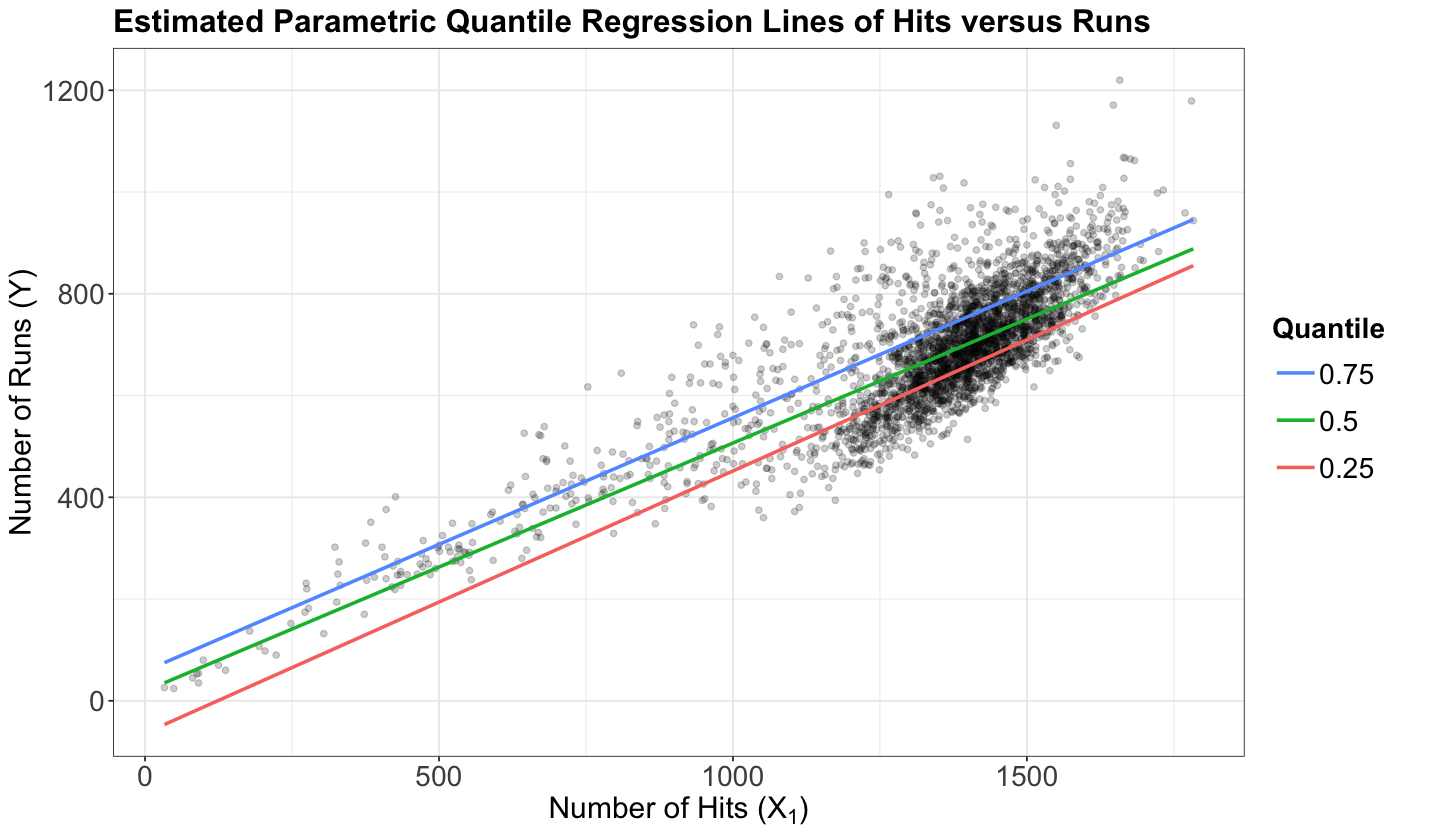

In [12]:
ggplot(teams, aes(hits, runs)) +
  geom_point(alpha = 0.2, colour = "black") +
  geom_quantile(
    quantiles = c(0.25, 0.5, 0.75), aes(colour = as.factor(after_stat(quantile))),
    formula = y ~ x, linewidth = 1
  ) +
  theme_bw() +
  labs(
    x = expression(paste("Number of Hits (", X[1], ")")),
    y = "Number of Runs (Y)"
  ) +
  theme(
    plot.title = element_text(size = 19, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 18),
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm")),
    legend.title = element_text(size = 17, face = "bold"),
    legend.key.size = unit(1, "cm")
  ) +
  guides(colour = guide_legend(title = "Quantile", reverse = TRUE)) +
  ggtitle("Estimated Parametric Quantile Regression Lines of Hits versus Runs")

The above plot shows that the $0.75$-Quantile regression has the largest estimate for the intercept, followed by the $0.5$-Quantile regression. Finally, $0.25$-Quantile regression shows the smallest estimate for the intercept.

```{important}
Again, a fundamental characteristic of a $\tau$-Quantile regression (**either parametric or non-parametric**) is that we will practically have the $\tau \times 100\%$ of our observed responses below our estimated regression line via $\hat{\beta}_0(\tau), \hat{\beta}_1(\tau), \dots, \hat{\beta}_k(\tau)$.
```

Once we have seen this pattern on the estimated regression lines for quantiles $\tau = 0.25, 0.5, 0.75$, let us check how the fidelity function {eq}`fidelity-function` behaves so we can understand it more. 

**In general for $k$ regressors, assume we have the same set of regressor values $x_{i,1}, \dots, x_{i,k}$ in the panels below ($\tau = 0.25, 0.5, 0.75$). Moreover, we will have the corresponding set of estimates $\hat{\beta}_0(\tau), \hat{\beta}_1(\tau), \dots, \hat{\beta}_k(\tau)$ by quantile $\tau = 0.25, 0.5, 0.75$.** 

Having said all this, note we have the values of the corresponding fidelity function {eq}`fidelity-function` on the $y$-axis, whereas we have the corresponding values for the residual 

$$e_i = y_i - \overbrace{\big[\hat{\beta_0}(\tau) + \hat{\beta_1}(\tau) x_{i,1} + \ldots + \hat{\beta_k}(\tau) x_{i,k}\big]}^{\hat{y}_i}$$ 
$$e_i = y_i - \hat{y}_i$$

on the $x$-axis.

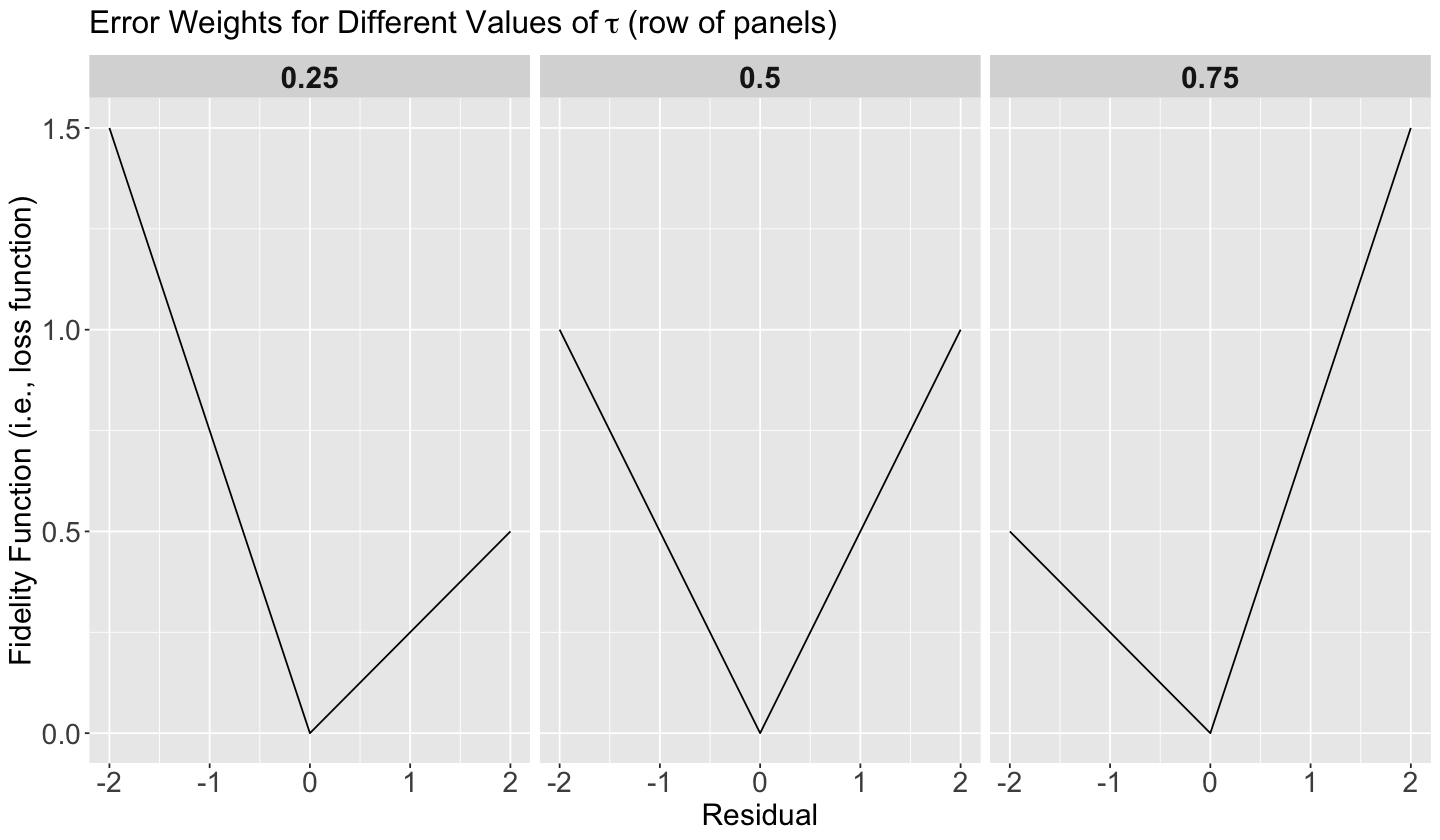

In [13]:
error_data <- tibble(
  residual = seq(-2, 2, 0.1),
  "0.25" = (0.25 - (residual < 0)) * residual,
  "0.5" = (0.5 - (residual < 0)) * residual,
  "0.75" = (0.75 - (residual < 0)) * residual
) %>%
  gather(key = tau, value = error_function, "0.25", "0.5", "0.75")

error_data |>
  ggplot() +
  facet_grid(cols = vars(tau)) +
  geom_line(aes(residual, error_function)) +
  ggtitle(bquote("Error Weights for Different Values of" ~ tau ~ "(row of panels)")) +
  theme(
    plot.title = element_text(size = 19), 
    strip.text = element_text(size = 18, face = "bold"),
    axis.text = element_text(size = 17), 
    axis.title = element_text(size = 18)
  ) +
  labs(x = "Residual", y = "Fidelity Function (i.e., loss function)")

We will go panel by panel from left to right:

$\tau = 0.25$

Recall the **residual** is

$$e_i = y_i - \overbrace{\big[\hat{\beta_0}(\tau) + \hat{\beta_1}(\tau) x_{i,1} + \ldots + \hat{\beta_k}(\tau) x_{i,k}\big]}^{\hat{y}_i}.$$

Note that for low values of $\tau$, **we consider overpredicting** 

$$e_i = y_i - \hat{y}_i < 0$$ 

**WORSE than underpredicting**

$$e_i = y_i - \hat{y}_i > 0.$$

Note how steeper is the penalty (on the $y$-axis) when we overestimate (the negative part on the $x$-axis). So, we prefer to err on the side of underestimating (the positive part on the $x$-axis).

```{important} 
Since we prefer to err on the side of underestimating in this scenario, to decrease the error function value even more we need to provide **smaller** estimated values for $\hat{\beta_0}(\tau), \hat{\beta_1}(\tau), \dots, \hat{\beta_k}(\tau)$. In a 2-$d$ scenario ($Y$ versus a single $X_1$ with $\hat{\beta_0}(\tau)$ and $\hat{\beta_1}(\tau)$ as regression parameters **where there is a positive relationship between $X_1$ and $Y$**), this will **pull down** the estimated regression line in a plot.
```

$\tau = 0.5$

For $\tau = 0.5$, **we care equally about underpredicting and overpredicting**. This corresponds to the median value. 

$\tau = 0.75$

Recall the **residual** is

$$e_i = y_i - \overbrace{\big[\hat{\beta_0}(\tau) + \hat{\beta_1}(\tau) x_{i,1} + \ldots + \hat{\beta_k}(\tau) x_{i,k}\big]}^{\hat{y}_i}$$

For high values of $\tau$, it is the opposite. **We consider underpredicting**

$$e_i = y_i - \hat{y}_i > 0$$ 

**WORSE than overpredicting**

$$e_i = y_i - \hat{y}_i < 0.$$ 

Note how steeper is the penalty (on the $y$-axis) when we underestimate (the positive part on the $x$-axis). So, we prefer to err on the side of overestimating (the negative part on the $x$-axis).

```{important} 
Since we prefer to err on the side of overestimating in this scenario, to decrease the error function on the $y$-axis even more we need to provide **larger** estimated values for $\hat{\beta_0}(\tau), \hat{\beta_1}(\tau), \dots, \hat{\beta_k}(\tau)$. In a 2-$d$ scenario ($Y$ versus a single $X_1$ with $\hat{\beta_0}(\tau)$ and $\hat{\beta_1}(\tau)$ as regression parameters **where there is a positive relationship between $X_1$ and $Y$**), this will **pull up** the estimated regression line in a plot.
```

### 3.2. Estimation

If our **linear systematic component** has $k$ regression parameters (**intercept AND coefficients**), then our **estimated Quantile regression function** will interpolate $k$ points. For example, if we are fitting a line $Q_i( \tau | X_{i, 1} = x_{i, 1}) = \beta_0(\tau) + \beta_1(\tau) x_{i, 1}$, we are estimating two parameters: $\hat{\beta}_0(\tau)$ and $\hat{\beta}_1(\tau)$. So, our fitted line passes through two points.

**As we already mentioned**, when we use the $\tau$-quantile with a training set size of $n$, approximately $n \times \tau$ points will be under the curve and $n \times (1 - \tau)$ will be above the curve. For instance, if we have $n = 100$ points to fit the $0.7$-quantile, then:

- The number of points above the line will be approximately 30.
- The number of points below the line will be approximately 70.
    
The "approximately" comes because we will have $k$ points **ON** the estimated regression function.

Let us consider the `teams` dataset again. In this example, we will estimate the quantiles of `runs` as a **linear function** of `hits`. Below, you can find the code to obtain these estimated $0.25$, $0.5$, and $0.75$-quantile regression lines (via `geom_quantile()`). **This code shows the same plot we saw beforehand.**

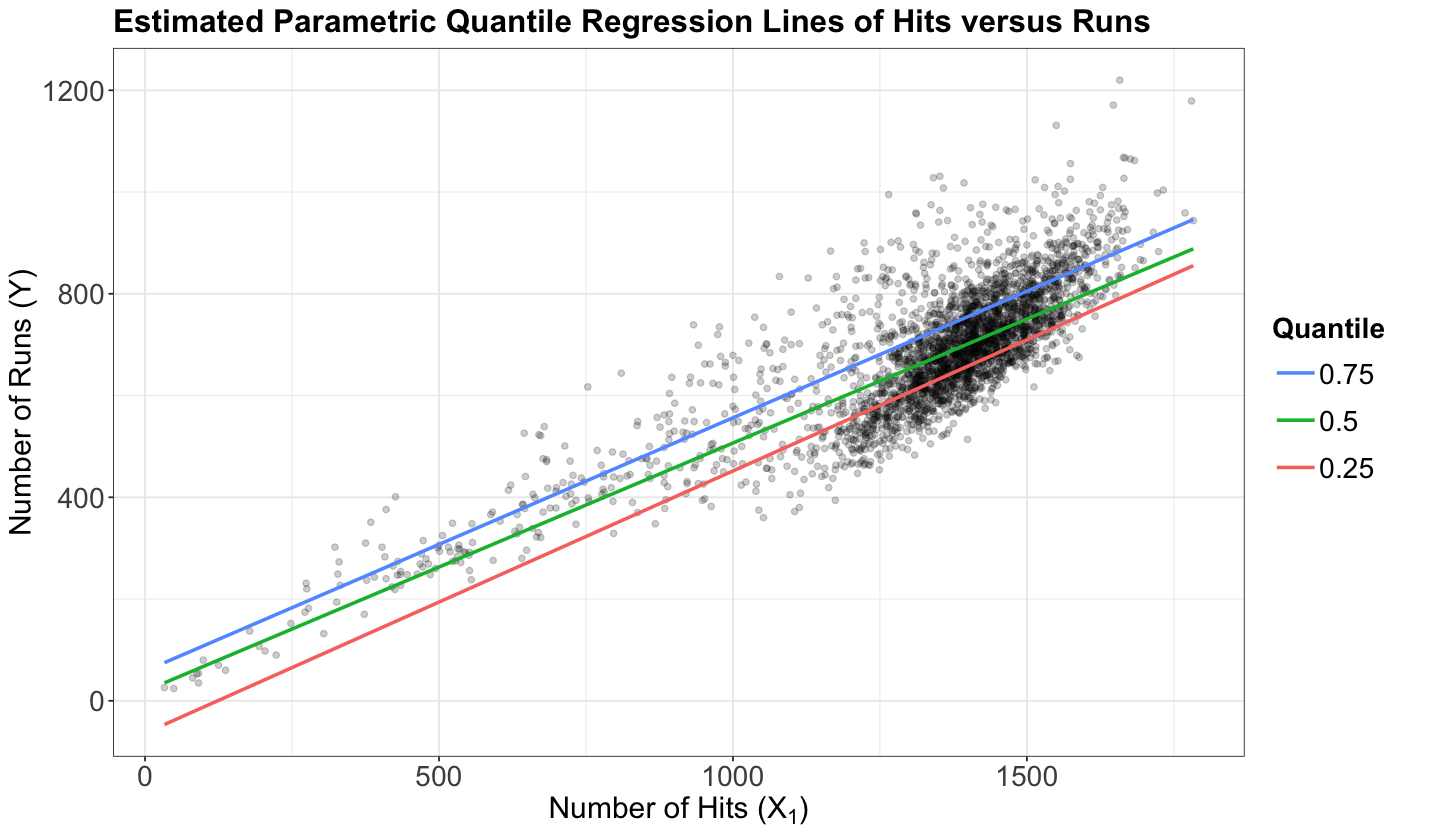

In [14]:
estimated_quantile_regression_lines <- ggplot(teams, aes(hits, runs)) +
  geom_point(alpha = 0.2, colour = "black") +
  geom_quantile(
    quantiles = c(0.25, 0.5, 0.75), aes(colour = as.factor(after_stat(quantile))),
    formula = y ~ x, linewidth = 1
  ) +
  theme_bw() +
  labs(
    x = expression(paste("Number of Hits (", X[1], ")")),
    y = "Number of Runs (Y)"
  ) +
  theme(
    plot.title = element_text(size = 19, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 18),
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm")),
    legend.title = element_text(size = 17, face = "bold"),
    legend.key.size = unit(1, "cm")
  ) +
  guides(colour = guide_legend(title = "Quantile", reverse = TRUE)) +
  ggtitle("Estimated Parametric Quantile Regression Lines of Hits versus Runs")

estimated_quantile_regression_lines

Furthermore, from `quantreg` package, we will use the `rq()` function to fit the parametric Quantile regression at $\tau = 0.25, 0.5, 0.75$. It has a `formula` argument as the previous fitting functions along with `data`. This function also allows us to fit as many Quantile regressions as we want via `tau`.

```{important}
As in the case of OLS, modelling estimates are obtained via an optimization procedure which minimizes the fidelity function {eq}`fidelity-function`.
```

To get the modelling output in a non-`tidy()` format, we use the function `summary()` as shown below. Note there is **more than one way** to obtain the standard errors and $p$-values of the regression estimates. For the purpose of this course, we will use the **pairwise bootstrapping method** via the arguments `se = "boot"` and `bsmethod = "xy"`. Specifically, for this example, we will use `R = 1000` **replicates** in function `summary()`. 

In a general case with $k$ regressors and a response $y_i$ (for $i = 1, 2, \dots, k$) for a training set of size $n$ for the $\tau$-quantile, the **pairwise bootstrapping method** **resamples with replacement** $n$ data points $(x_{i, 1}, x_{i, 2}, \dots, x_{i, k}, y_i)$  from the original training set and refit the $\tau$-Quantile regression model `R` **times** (which are the bootstrapping **replicates**). Roughly speaking, the method is a bit similar to the **percentile method from DSCI 552** (but not the same!) which delivers confidence intervals (CI) for our modelling estimates.

```{important}
More information about this method can be found in the [function's documentation](https://www.rdocumentation.org/packages/quantreg/versions/5.99.1/topics/boot.rq).
```

Finally, by default (**and in a really misleading way!**), the name of the test statistic (which is the ratio between the estimate in column `Value` and the standard error in column `Std. Error`) is named `t value`, and the empirical $p$-value is named `Pr(>|t|)`. **That said, for the pairwise bootstrapping method, the $t$-distribution is not used at all!**

In [15]:
fit_rq_teams <- rq(formula = runs ~ hits, data = teams, tau = c(0.25, 0.5, 0.75))

# Reproducibility!
set.seed(562) # Let us recall that bootstrapping is a simulation-based inferential method.

param_QR_summary <- summary(fit_rq_teams, se = "boot", R = 1000, bsmethod = "xy")
param_QR_summary


Call: rq(formula = runs ~ hits, tau = c(0.25, 0.5, 0.75), data = teams)

tau: [1] 0.25

Coefficients:
            Value     Std. Error t value   Pr(>|t|) 
(Intercept) -63.63585  22.64757   -2.80983   0.00499
hits          0.51541   0.01623   31.74914   0.00000

Call: rq(formula = runs ~ hits, tau = c(0.25, 0.5, 0.75), data = teams)

tau: [1] 0.5

Coefficients:
            Value    Std. Error t value  Pr(>|t|)
(Intercept) 19.19713  7.70558    2.49133  0.01278
hits         0.48746  0.00588   82.97028  0.00000

Call: rq(formula = runs ~ hits, tau = c(0.25, 0.5, 0.75), data = teams)

tau: [1] 0.75

Coefficients:
            Value    Std. Error t value  Pr(>|t|)
(Intercept) 58.56682 10.43408    5.61303  0.00000
hits         0.49770  0.00753   66.06291  0.00000

### 3.3. Inference

In terms of inference, we use the fitted model to identify the relationship between the $\tau$-quantile in our response and regressors. We will need the $j$th estimated regression parameter $\hat{\beta}_j(\tau)$ and its corresponding variability which is reflected in the **boostrapped standard error** of the estimate, $\mbox{se}\left[\hat{\beta}_j (\tau) \right]$. To determine the statistical significance of $\hat{\beta}_j(\tau)$, we use the **test statistic**

$$t_j = \frac{\hat{\beta}_j(\tau)}{\mbox{se}\left[\hat{\beta}_j (\tau) \right]}$$

to test the hypotheses

```{math}
\begin{gather*}
H_0: \beta_j(\tau) = 0 \\
H_a: \beta_j(\tau) \neq 0.
\end{gather*}
```

As discussed above, we can obtain the corresponding **empirical $p$-values** for each $\beta_j(\tau)$ associated with the $t$-values under the null hypothesis $H_0$. **The smaller the $p$-value, the stronger the evidence against the null hypothesis $H_0$ in our sample**. Hence, small $p$-values (less than the significance level $\alpha$) indicate that the data provides evidence in favour of **association** (**or causation in the case of an experimental study!**) between the $\tau$-quantile in our response and the $j$th regressor. Similarly, given a specified $(1-\alpha) \times 100\%$ level of confidence, we can construct **empirical confidence intervals** for the corresponding true value of $\beta_j$ via the **bootstrapping sampling distribution** using the 

Let us recall our inquiry (1):

> 1. Previous research has shown you that a large number of runs is associated with a large number of hits. Having said that, **for those teams at the upper 75% threshold in runs**, is this association significant? If so, by how much?

This inferential question corresponds to the estimated $0.75$-Quantile regression:

In [16]:
param_QR_summary[3]

[[1]]

Call: rq(formula = runs ~ hits, tau = c(0.25, 0.5, 0.75), data = teams)

tau: [1] 0.75

Coefficients:
            Value    Std. Error t value  Pr(>|t|)
(Intercept) 58.56682 10.43408    5.61303  0.00000
hits         0.49770  0.00753   66.06291  0.00000


Our sample gives us evidence to reject $H_0$ ($p\text{-value} < .001$). So `hits` is statistically associated to the $0.75$-quantile of `runs`.

```{important}
It is also possible to obtain confidence intervals (CIs) for each regression estimate. That said, **not** all the inferential methods for quantile regression offer this option, and bootstrapping is one of them. For instance, the `rank` method in [summary.rq()](https://search.r-project.org/CRAN/refmans/quantreg/html/summary.rq.html) allows us to obtain the CIs:

> "rank" which produces confidence intervals for the estimated parameters by inverting a rank test as described in Koenker (1994). This method involves solving a parametric linear programming problem, and for large sample sizes can be extremely slow, so by default it is only used when the sample size is less than 1000, see below. The default option assumes that the errors are iid, while the option iid = FALSE implements a proposal of Koenker Machado (1999). See the documentation for rq.fit.br for additional arguments.
```

### 3.4. Coefficient Intepretation

We can quantify the statistical association of `hits` and the $0.75$-quantile of `runs` via the corresponding $\hat{\beta}_1(0.75)$.

In [17]:
param_QR_summary[3]

[[1]]

Call: rq(formula = runs ~ hits, tau = c(0.25, 0.5, 0.75), data = teams)

tau: [1] 0.75

Coefficients:
            Value    Std. Error t value  Pr(>|t|)
(Intercept) 58.56682 10.43408    5.61303  0.00000
hits         0.49770  0.00753   66.06291  0.00000


The interpretation is: 

> For each one hit increase, the $0.75$-quantile of runs will increase by 0.5.

```{important}
In general, coefficient interpretation works as in OLS (for continuous and categorical regressors). Nevertheless, this interpretation will be targeted towards the $\tau$-quantile of the response, not the mean.
```

### 3.5. Predictions

Now, let us check our inquiry (2):

> 2. **For any given team that scores 1000 hits in a future tournament**, how many runs can this team score with a 50% chance (centred around this future tournament's median runs)?

We can obtain this prediction via our $0.25$ and $0.75$-Quantile regressions with `predict()`.

In [18]:
round(predict(fit_rq_teams, newdata = data.frame(hits = 1000)), 0)

,tau= 0.25,tau= 0.50,tau= 0.75
1,452,507,556


Thus, our predictive inquiry can be answered as: **"for any given team that scores 1000 hits in a future tournament, it is estimated to have a 50% ($0.75 - 0.25 \times 100\%$) chance to have between 452 and 556 runs."**

```{important}
**This is a probabilistic prediction!**
```

Note we could also say that this team: 

- has a 25% ($1 - 0.75 \times 100\%$) chance of achieving **over** 556 runs,
- has a 25% ($0.25 \times 100\%$) chance of getting **less** than 452 runs,
- and would typically get 507 runs (**median**).

amongst other things.

## 4. Non-Parametric Quantile Regression

The predictive inquiry (2) can also be dealt with via **non-parametric Quantile regression**. This class of Quantile regression implicates **no model function specification** (i.e., a linear combination such as the **systematic component** in the parametric Quantile regression). The core idea is to allow the model to capture the local behaviour of the data (i.e., **capturing its local structure**).

A non-parametric Quantile regression relies on what we call **splines**. A spline is a mathematical function that is composed of **piecewise polynomials**. Statistically speaking, in Regression Analysis, we use splines as another form of **local regression**.

```{admonition} Note
:class: note
The math behind this non-parametric model is a bit intricate, and it will be out of the scope of this course. If you would like to check the model more in detail, you can check the original paper called [**Quantile Smoothing Splines**](http://www.econ.uiuc.edu/~roger/research/qss/qss1.pdf) by Koerner et al. (1994). 
```

### 4.1. General Modelling Framework

As in the modelling approaches we saw in {doc}`lecture6_local_regression`, the struggle is choosing **how local** our model should be. In other words, what is the neighbourhood of a point $x$? A certain parameter will control this. We will call it `lambda`, a **penalization** parameter:

- A **small neighbourhood** (i.e., a small `lambda`) will provide a better approximation, but with too much variability -- the model will not be smooth, and **we might be prone to overfitting**.
- A **too-large neighbourhood** (i.e., a big `lambda`) will lose local information favouring smoothness, going towards a global model, and **we might be prone to underfitting**.

### 4.2. Estimation

In `R`, non-parametric Quantile regression is performed using the function `rqss()` from library `quantreg`. It also works somewhat similarly to what we are used to with the `lm()` and `glm()` functions.

However, in `rqss()`, each regressor must be introduced in the formula using the `qss()` function (as **additive non-parametric terms**). For example, `qss(x, lambda = 3)`.

The syntax would be:

```
rqss(y ~ qss(x, lambda = 10), tau = 0.5, data = my_data)
```

We use `rqss()` to run a non-parametric Quantile regression with `runs` as the response and `hits` as the regressor. **For the sake of our previous predictive inquiry**, we use a `tau = 0.25` and `tau = 0.75`:

> **For any given team that scores 1000 hits in a future tournament**, how many runs can this team score with a 50% chance (centred around this future tournament's median runs)?

Note `rqss()` does not allow multiple values for `tau`. Therefore, we fit a model per `tau` value. Here, we try a `lambda = 100`.

In [19]:
rqss_model_0.25_lambda_100 <- rqss(runs ~ qss(hits, lambda = 100), tau = 0.25, data = teams)
summary(rqss_model_0.25_lambda_100)

Formula:
runs ~ qss(hits, lambda = 100)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)   14.841      9.381   1.582    0.114

Approximate significance of qss terms:
     EDF Lambda Penalty F value Pr(>F)    
hits  18    100   3.223    2809 <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Quantile Fidelity at tau = 0.25  is      63071.4
  Effective Degrees of Freedom = 21        Sample Size = 3045

In [20]:
rqss_model_0.75_lambda_100 <- rqss(runs ~ qss(hits, lambda = 100), tau = 0.75, data = teams)
summary(rqss_model_0.75_lambda_100)

Formula:
runs ~ qss(hits, lambda = 100)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)    12.93      10.65   1.214    0.225

Approximate significance of qss terms:
     EDF Lambda Penalty F value Pr(>F)    
hits  17    100   9.589   24770 <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Quantile Fidelity at tau = 0.75  is      76223.2
  Effective Degrees of Freedom = 19        Sample Size = 3045

Then, we plot the two model functions on the data plot. This is basically our **prediction band** (which can also apply to our parametric models!).

In [21]:
grid_teams_0.25_lambda_100 <- teams |> 
  data_grid(hits) |> 
  add_predictions(rqss_model_0.25_lambda_100)

grid_teams_0.75_lambda_100 <- teams |> 
  data_grid(hits) |> 
  add_predictions(rqss_model_0.75_lambda_100)

non_param_teams_scatterplot_lambda_100 <- teams_scatterplot +
  geom_line(aes(hits, pred, colour = "0.75"), data = grid_teams_0.75_lambda_100, linewidth = 1) +
  geom_line(aes(hits, pred, colour = "0.25"), data = grid_teams_0.25_lambda_100, linewidth = 1) +
  theme(
    plot.title = element_text(size = 19),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 18),
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm")),
    legend.title = element_text(size = 17, face = "bold"),
    legend.key.size = unit(1, "cm")
  ) +
  scale_color_manual(name = "Quantile", values = c("0.75" = "red", "0.25" = "blue")) +
  guides(colour = guide_legend(reverse = TRUE)) +
  ggtitle(bquote("Estimated Non-Parametric Quantile Regression Lines of Hits versus Runs with" ~ lambda ~ "= 100"))

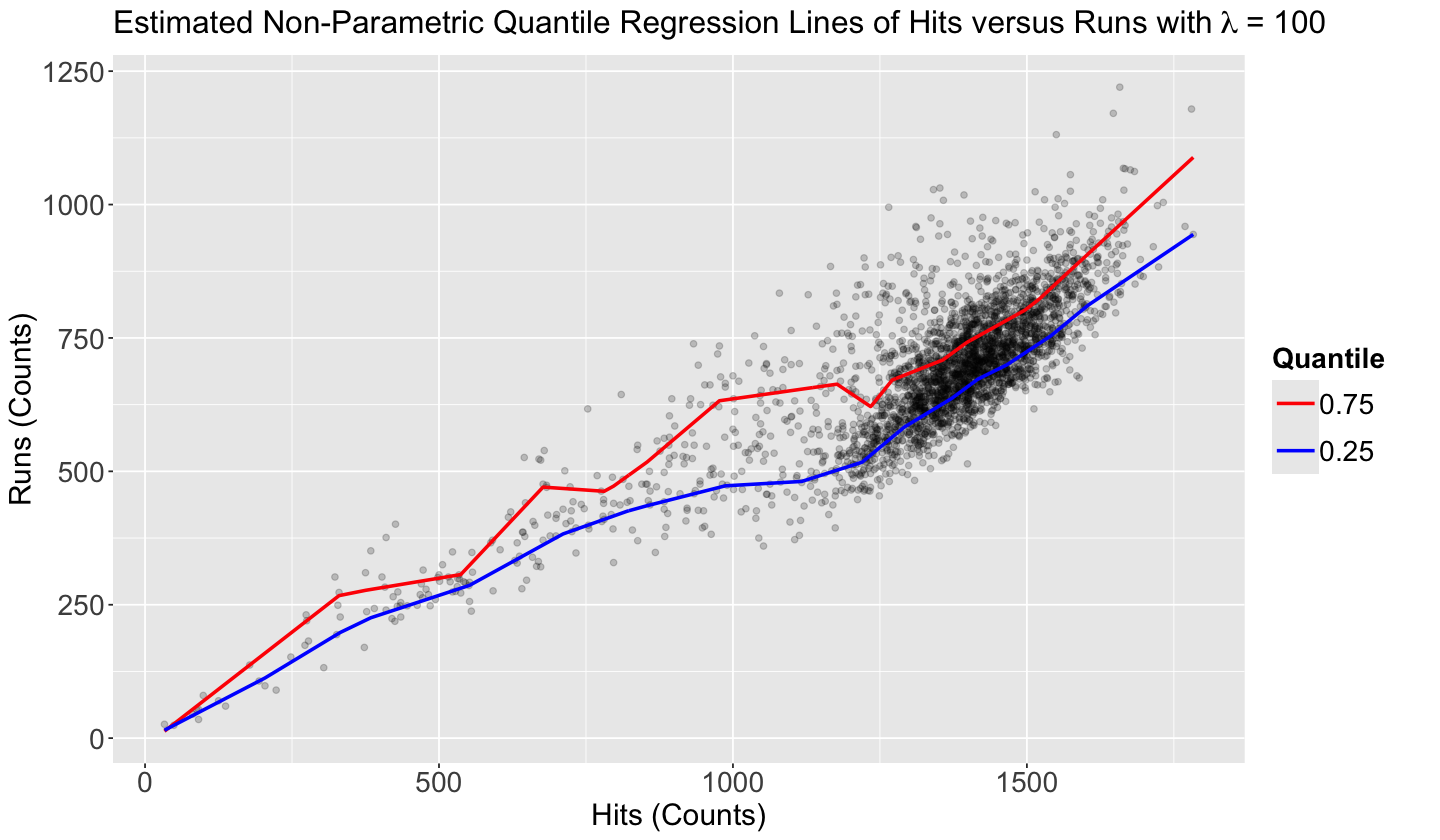

In [22]:
non_param_teams_scatterplot_lambda_100

**What if we use `lambda = 10`?** Our estimated functions **will not be that smooth** anymore, there will be **more variability** on the prediction.

In [23]:
rqss_model_0.25_lambda_10 <- rqss(runs ~ qss(hits, lambda = 10), tau = 0.25, data = teams)
summary(rqss_model_0.25_lambda_10)

Formula:
runs ~ qss(hits, lambda = 10)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)    17.45      15.29   1.141    0.254

Approximate significance of qss terms:
     EDF Lambda Penalty F value Pr(>F)    
hits  72     10   116.3    1929 <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Quantile Fidelity at tau = 0.25  is      62178.9
  Effective Degrees of Freedom = 80        Sample Size = 3045

In [24]:
rqss_model_0.75_lambda_10 <- rqss(runs ~ qss(hits, lambda = 10), tau = 0.75, data = teams)
summary(rqss_model_0.75_lambda_10)

Formula:
runs ~ qss(hits, lambda = 10)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)    26.00      15.19   1.712    0.087 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of qss terms:
     EDF Lambda Penalty F value Pr(>F)    
hits  71     10   171.7    5409 <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Quantile Fidelity at tau = 0.75  is        74469
  Effective Degrees of Freedom = 75        Sample Size = 3045

In [25]:
grid_teams_0.25_lambda_10 <- teams |> 
  data_grid(hits) |> 
  add_predictions(rqss_model_0.25_lambda_10)

grid_teams_0.75_lambda_10 <- teams |> 
  data_grid(hits) |>
  add_predictions(rqss_model_0.75_lambda_10)

non_param_teams_scatterplot_lambda_10 <- teams_scatterplot +
  geom_line(aes(hits, pred, colour = "0.75"), data = grid_teams_0.75_lambda_10, linewidth = 1) +
  geom_line(aes(hits, pred, colour = "0.25"), data = grid_teams_0.25_lambda_10, linewidth = 1) +
  theme(
    plot.title = element_text(size = 19),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 18),
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm")),
    legend.title = element_text(size = 17, face = "bold"),
    legend.key.size = unit(1, "cm")
  ) +
  scale_color_manual(name = "Quantile", values = c("0.75" = "red", "0.25" = "blue")) +
  guides(colour = guide_legend(reverse = TRUE)) +
  ggtitle(bquote("Estimated Non-Parametric Quantile Regression Lines of Hits versus Runs with" ~ lambda ~ "= 10"))

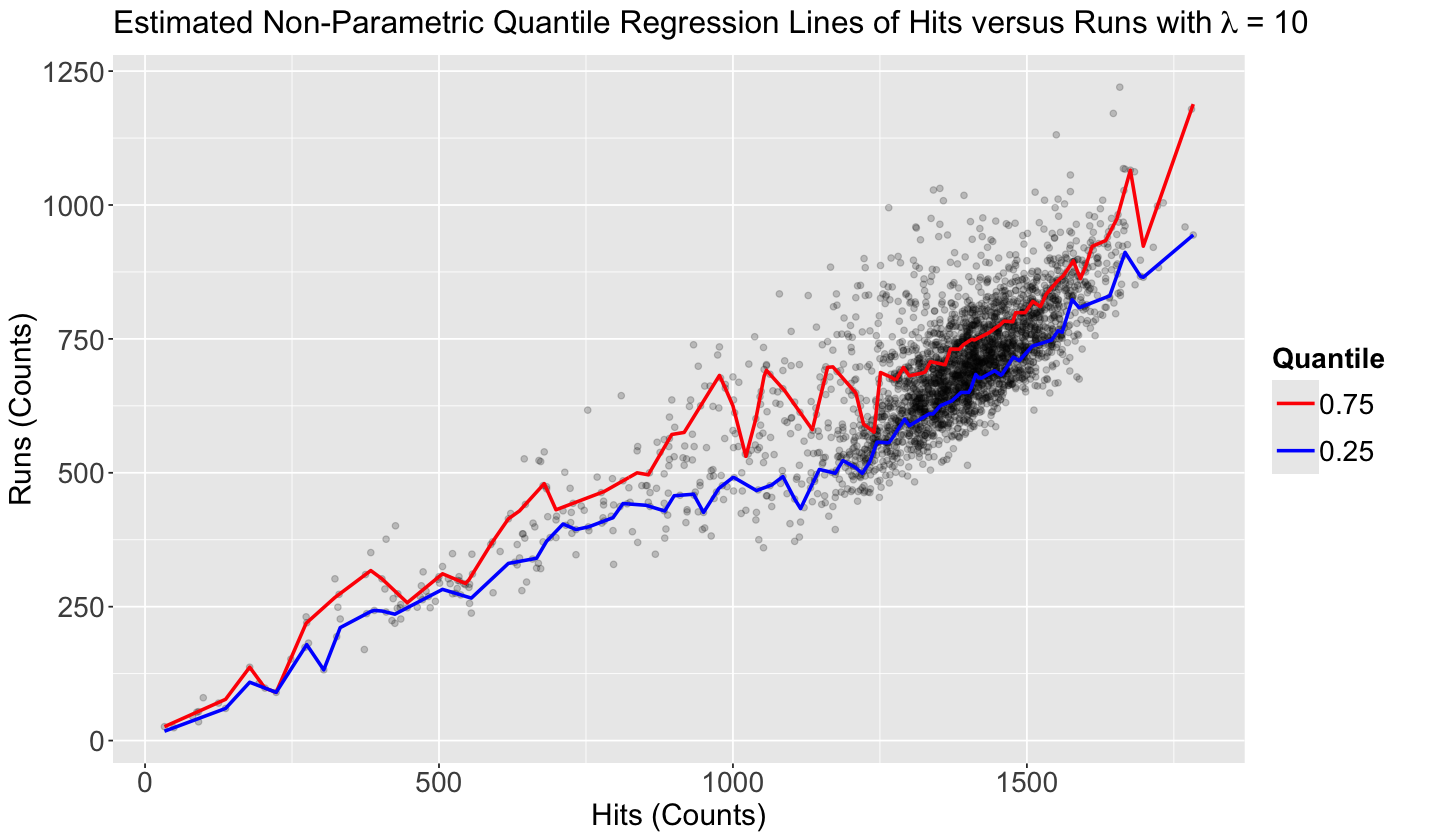

In [26]:
non_param_teams_scatterplot_lambda_10

```{admonition} Note
:class: note
Note that the output from `rqss()` via `summary()` still indicates the non-parametric model has a `(Intercept)` whose statistical significance is tested via a $t$-value along with the approximate significance of `qss` terms via an $F$-value. However, the [**function's documentation**](https://web.mit.edu/~r/current/arch/i386_linux26/lib/R/library/quantreg/html/summary.rqss.html) indicates the following about the summary of this class of model:

> This is a highly experimental function intended to explore inferential methods for `rqss` fitting. The function is modeled after `summary.gam` in Simon Wood's (2006) `mgcv` package. (Of course, Simon should not be blamed for any deficiencies in the current implementation. The basic idea is to condition on the lambda selection and construct quasi-Bayesian credibility intervals based on normal approximation of the "posterior," as computed using the Powell kernel estimate of the usual quantile regression sandwich. See `summary.rq` for further details and references. The function produces a conventional coefficient table with standard errors t-statistics and p-values for the coefficients on the parametric part of the model, and another table for additive nonparametric effects. The latter reports F statistics intended to evaluate the significance of these components individually. In addition the fidelity (value of the QR objective function evaluated at the fitted model), the effective degrees of freedom, and the sample size are reported.

The above disclaimer refers to `summary.gam()`, which is the summary for modelling outputs related to Generalized Additive Models (GAMs). GAMs are another class of regression models where we can estimate a **systematic component** non-linearly. You can find fair introductory material on GAMs [**here**](https://m-clark.github.io/generalized-additive-models/preface.html).
```

As a sanity check, let us calculate the **proportion of points below** these estimated regression functions with $\lambda = 10$.

In [27]:
teams |>
  mutate(pred = predict(rqss_model_0.25_lambda_10, newdata = teams)[, 1]) |>
  summarise(prop_below_curve = mean(runs < pred))

prop_below_curve
<dbl>
0.2505747


In [28]:
teams |>
  mutate(pred = predict(rqss_model_0.75_lambda_10, newdata = teams)[, 1]) |>
  summarise(prop_below_curve = mean(runs < pred))

prop_below_curve
<dbl>
0.7500821


### 4.3. Prediction

Suppose that we go ahead with the non-parametric models with $\lambda = 10$, then we obtain the corresponding **probabilistic interval**:

In [29]:
as.vector(round(predict(rqss_model_0.25_lambda_10, newdata = data.frame(hits = 1000)), 0))

[1] 491

In [30]:
as.vector(round(predict(rqss_model_0.75_lambda_10, newdata = data.frame(hits = 1000)), 0))

[1] 625

Thus, our predictive inquiry can be answered as: 

> For any given team that scores 1000 hits in a future tournament, it is estimated to have a 50% ($0.75 - 0.25 \times 100\%$) chance to have between 491 and 625 runs.

```{important}
Having said all this regarding parametric and non-parametric Quantile regressions, you might wonder: **when to use what?**

In general, non-parametric Quantile regression might be adequate for predictive inquiries via non-linear training data. On the other hand, untangling an interpretable numeric association (or causation!) between our quantile response and some regressor would imply parametric Quantile regression.
```

(quantile-regression-discrete-data)=
## (Optional) 5. Quantile Regression and Discrete Data

We previously stated that to use Quantile regression with a count-type response, we would need to make extra adjustments if the response is **much less scattered**. Hence, let us introduce a dataset with this condition.

### 5.1. The Crabs Dataset

The data frame `crabs` ([Brockmann, 1996](https://ubc.summon.serialssolutions.com/2.0.0/link/0/eLvHCXMwrV3JasMwEBUlpZBLl7Sl6YY_oE4sy5sgFEpICKU9NadcjFYSmtghCyRf0t-tJC_EPhRaepMHS8jSSPM0M3oGALkdx67tCYRyKV0GacCp9CBX60RCySMcYiigy2qpOq_F1ZiMLqL0v-mFYrZvvd4JXXcPEnOUZbU1z6W-fxdoh6eO-XQUvDyGCnXrbK_hxCkDDCHKgs9KH20FelDOR_pzWxXbdYhljTEanoF10e8iC6V2SbDK9Pg_H3gOTnPsar1kynYBjkTSAs1yC923wMkkNaVL8NVbkNXn8wcxjJ8b0euaZysTvyuzVJUYH9i6Kpsl1ijVOSbTtPZ2f6V6nYuectnbbLGdb2tNLNP5fjkVi1J-BcbDwbg_svOfQNhMIRdsu4KHEnIsIiQYJoGQvsKQmAuOsE8lojRnrPEIlZQHHIUEEs8PBVHQjaJr0EjSRNwAS8ebmMNk4DHkRYgQSt2ARoxRnzuhJG2AitmNlxnVR3x4REI41sMf6-GP8-GPd20QmVn7RZV4MB7p0u3fq96BZpY-rn1B96CxWW3FgyGOeDR6_g1rIQSN)) is a dataset detailing the **counts of satellite male crabs** residing around a female crab nest. The code below renames the original response's name, `satell`, to `n_males`. We will work with the continuous carapace `width` as a regressor.

``` {figure} ../img/crab.png
:height: 350px
Hello! I'm the crab, again!
```

```{admonition} The Crabs Dataset
The data frame `crabs` contains 173 observations on horseshoe crabs (Limulus polyphemus). The response is **the count of male crabs** (`n_males`) around a female breeding nest. It is subject to four explanatory variables **related to the female crab**: `color` of the prosoma with four levels (categorical factor-type), the condition of the posterior `spine` with three levels (categorical factor-type), the continuous variables carapace `width` (cm), and `weight` (g).
```

In [31]:
data(crabs)
crabs_raw <- crabs |>
  rename(n_males = satell) |>
  dplyr::select(width, n_males)
crabs_raw

width,n_males
<dbl>,<int>
28.3,8
22.5,0
26.0,9
⋮,⋮
28.0,0
27.0,0
24.5,0


### 5.2. Initial Model Estimation

Next, let us fit a sequence of quantiles $\tau$ to the data, then add the fitted values to the dataset. This is what `geom_quantile()` does behind the scenes.

In [32]:
# Copying the raw data.
crabs <- crabs_raw

# Specifying the desired quantiles.
tau <- seq(0.2, 0.8, 0.2)

# Fitting the parametric model for the desired quantiles.
fit_rq_crabs <- rq(n_males ~ width, data = crabs, tau = tau)

pred <- fit_rq_crabs$fitted.values
colnames(pred) <- round(fit_rq_crabs$tau, 2)

# Creating a tibble with the fitted values for each quantile model.
pred <- as_tibble(pred, colnames = fit_rq_crabs$tau) |>
  mutate(width = crabs$width) |>
  gather(key = tau, value = pred, -width) |>
  mutate(tau = as.double(tau))

# Joining the pred tibble to the crabs tibble.
crabs <- crabs_raw |>
  left_join(pred, relationship = "many-to-many")

crabs

Joining with `by = join_by(width)`


width,n_males,tau,pred
<dbl>,<int>,<dbl>,<dbl>
28.3,8,0.2,0
28.3,8,0.2,0
28.3,8,0.2,0
⋮,⋮,⋮,⋮
24.5,0,0.8,4.604651
24.5,0,0.8,4.604651
24.5,0,0.8,4.604651


Now, let us check the `summary()` of `fit_rq_crabs` with `se = "boot"`, `bsmethod = "xy"`, and `R = 100` **replicates**

**Note that the estimated $0.2$-Quantile regression is providing estimates at zero!**

In [33]:
set.seed(562)

summary(fit_rq_crabs, se = "boot", bsmethod = "xy", R = 100)


Call: rq(formula = n_males ~ width, tau = tau, data = crabs)

tau: [1] 0.2

Coefficients:
            Value   Std. Error t value Pr(>|t|)
(Intercept) 0.00000 3.12555    0.00000 1.00000 
width       0.00000 0.12559    0.00000 1.00000 

Call: rq(formula = n_males ~ width, tau = tau, data = crabs)

tau: [1] 0.4

Coefficients:
            Value     Std. Error t value   Pr(>|t|) 
(Intercept) -11.00000   2.61026   -4.21414   0.00004
width         0.47619   0.11043    4.31233   0.00003

Call: rq(formula = n_males ~ width, tau = tau, data = crabs)

tau: [1] 0.6

Coefficients:
            Value     Std. Error t value   Pr(>|t|) 
(Intercept) -11.76000   3.26755   -3.59903   0.00042
width         0.56000   0.12500    4.47990   0.00001

Call: rq(formula = n_males ~ width, tau = tau, data = crabs)

tau: [1] 0.8

Coefficients:
            Value    Std. Error t value  Pr(>|t|)
(Intercept) -6.79070  6.70248   -1.01316  0.31241
width        0.46512  0.25347    1.83501  0.06824

Finally, let us plot the data and our fitted models (**one model for each quantile**).

In [34]:
p_crabs <- ggplot(crabs, aes(width, n_males)) +
  geom_point(alpha = 0.8) +
  theme_bw() +
  geom_line(aes(x = width, y = pred, colour = as.factor(tau)), linewidth = 1) +
  labs(
    x = "Carapace Width (mm)",
    y = "Number of Nearby Males"
  ) +
  theme(
    plot.title = element_text(size = 17, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 17),
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm")),
    legend.title = element_text(size = 17, face = "bold"),
    legend.key.size = unit(1, "cm")
  ) +
  guides(colour = guide_legend(title = "Quantile", reverse = TRUE)) +
  ggtitle("Estimated Parametric Quantile Regression Lines of Carapace Width versus Number of Nearby Males")

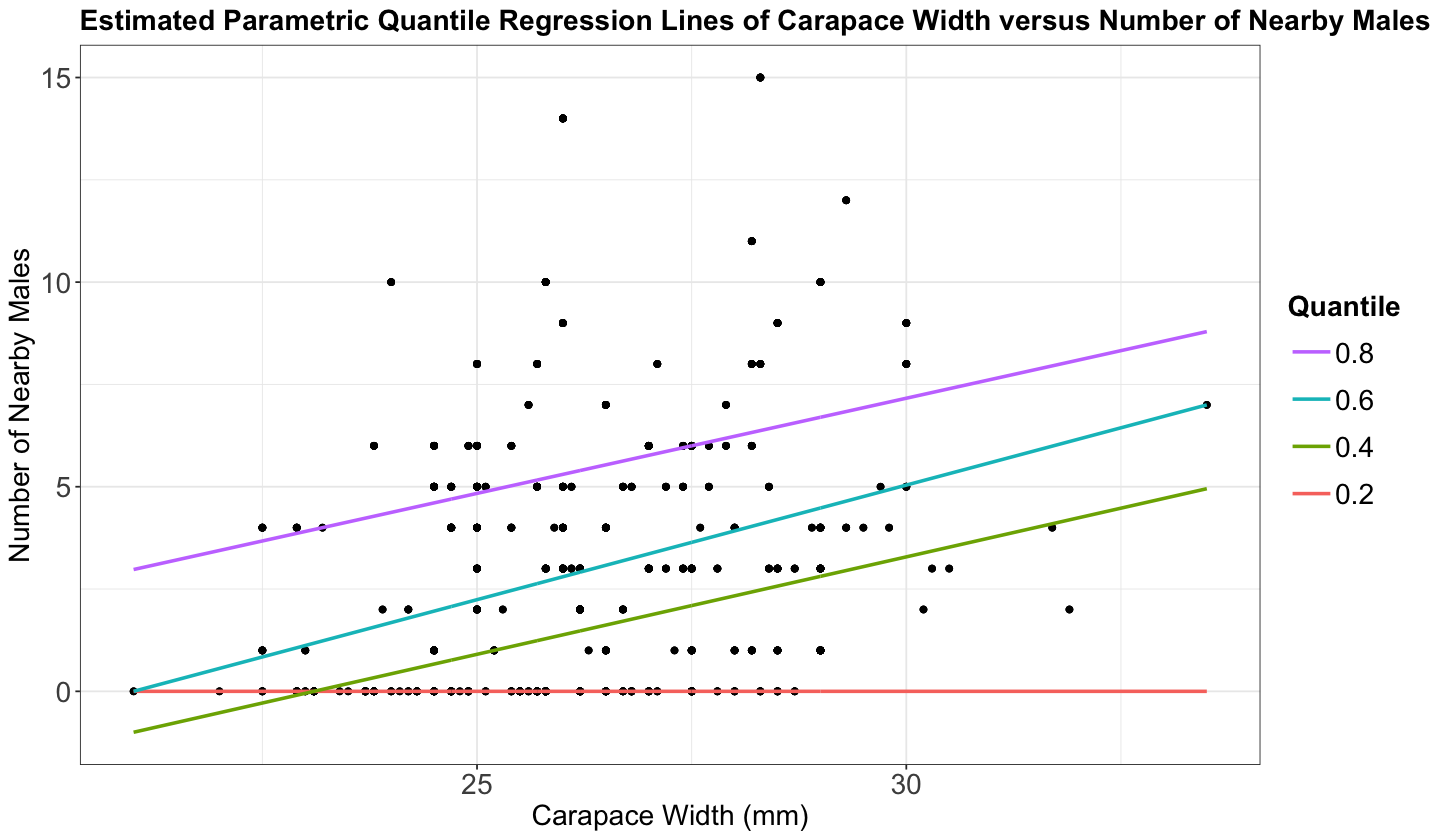

In [35]:
p_crabs 

There are **two important things** to observe here:

1. If we use lower quantiles, say less than 0.2, **the quantile regression is fitting a horizontal line at zero**.
2. Observe the model fitted for $\tau = 0.4$ and $\tau = 0.2$. For low values of the carapace width, they cross paths.

Furthermore, note that around 36% in `crabs_raw` of the response `n_males` is 0. **This is going to have an critical impact on the lower quantiles.**

In [36]:
round(nrow(crabs_raw |> filter(n_males == 0))/ nrow(crabs_raw), 2)

[1] 0.36

Let us estimate the **standard error** of our parameters for $\tau\in\{0.05, 0.1, 0.15, 0.2\}$.

In [37]:
set.seed(562)

summary(rq(n_males ~ width, data = crabs_raw, tau = c(0.05, 0.1, 0.15, 0.2)),
  se = "boot", bsmethod = "xy", R = 100)


Call: rq(formula = n_males ~ width, tau = c(0.05, 0.1, 0.15, 0.2), 
    data = crabs_raw)

tau: [1] 0.05

Coefficients:
            Value Std. Error t value Pr(>|t|)
(Intercept)   0     0        NaN     NaN     
width         0     0        NaN     NaN     

Call: rq(formula = n_males ~ width, tau = c(0.05, 0.1, 0.15, 0.2), 
    data = crabs_raw)

tau: [1] 0.1

Coefficients:
            Value   Std. Error t value Pr(>|t|)
(Intercept) 0.00000 1.16267    0.00000 1.00000 
width       0.00000 0.04506    0.00000 1.00000 

Call: rq(formula = n_males ~ width, tau = c(0.05, 0.1, 0.15, 0.2), 
    data = crabs_raw)

tau: [1] 0.15

Coefficients:
            Value   Std. Error t value Pr(>|t|)
(Intercept) 0.00000 2.15407    0.00000 1.00000 
width       0.00000 0.08496    0.00000 1.00000 

Call: rq(formula = n_males ~ width, tau = c(0.05, 0.1, 0.15, 0.2), 
    data = crabs_raw)

tau: [1] 0.2

Coefficients:
            Value   Std. Error t value Pr(>|t|)
(Intercept) 0.00000 3.17018    0.00000 1.000

But we have standard errors equal to zero in our lower quantile $\tau = 0.05$! **This does not make any sense from an inferential point of view.**

### 5.3. Model Estimation via `dither()`

For **discrete**, **count-type**, and **non-scattered** $Y$s, you can use the `dither()` function from package `quantreg` package to introduce some **random perturbation** (i.e., inducing random noise). The argument `type = "right"` specifies we only want strictly positive perturbations (since we are dealing with counts).

In [38]:
set.seed(123) # To ensure reproducibility in our random perturbation.
tau <-  c(0.05, 0.1, 0.15, 0.2)
fit_rq_crabs_dither <- rq(dither(n_males, type = "right", value = 1) ~ width, data = crabs_raw, tau = tau)

set.seed(562) # To ensure reproducibility in bootstrapping.
summary(fit_rq_crabs_dither, se = "boot", bsmethod = "xy", R = 100)


Call: rq(formula = dither(n_males, type = "right", value = 1) ~ width, 
    tau = tau, data = crabs_raw)

tau: [1] 0.05

Coefficients:
            Value    Std. Error t value  Pr(>|t|)
(Intercept) -2.86010  0.94506   -3.02636  0.00286
width        0.12127  0.03775    3.21218  0.00157

Call: rq(formula = dither(n_males, type = "right", value = 1) ~ width, 
    tau = tau, data = crabs_raw)

tau: [1] 0.1

Coefficients:
            Value    Std. Error t value  Pr(>|t|)
(Intercept) -3.67607  0.98679   -3.72527  0.00026
width        0.15884  0.03921    4.05152  0.00008

Call: rq(formula = dither(n_males, type = "right", value = 1) ~ width, 
    tau = tau, data = crabs_raw)

tau: [1] 0.15

Coefficients:
            Value    Std. Error t value  Pr(>|t|)
(Intercept) -4.14444  1.26250   -3.28272  0.00125
width        0.17998  0.04965    3.62513  0.00038

Call: rq(formula = dither(n_males, type = "right", value = 1) ~ width, 
    tau = tau, data = crabs_raw)

tau: [1] 0.2

Coefficients:
        

Then, we plot our in-sample predictions.

In [39]:
pred <- fit_rq_crabs_dither$fitted.values
colnames(pred) <- round(fit_rq_crabs_dither$tau, 2)

# Creating a tibble with the fitted values for each quantile model.
pred <- as_tibble(pred, colnames = fit_rq_crabs_dither$tau) |>
  mutate(width = crabs_raw$width) |>
  gather(key = tau, value = pred, -width) |>
  mutate(tau = as.double(tau))

# Joining the pred tibble to the crab tibble.
crabs_dither <-
  crabs_raw %>%
  left_join(pred, relationship = "many-to-many")

p_crabs_dither <- ggplot(crabs_dither, aes(width, n_males)) +
  geom_point(alpha = 0.8) +
  geom_line(aes(x = width, y = pred, colour = as.factor(tau)), linewidth = 1) +
  theme_bw() +
  labs(
    x = "Carapace Width (mm)",
    y = "Number of Nearby Males"
  ) +
  theme(
    plot.title = element_text(size = 17, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 17),
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm")),
    legend.title = element_text(size = 17, face = "bold"),
    legend.key.size = unit(1, "cm")
  ) +
  guides(colour = guide_legend(title = "Quantile", reverse = TRUE)) +
  ggtitle("Estimated Parametric Quantile Regression Lines of Carapace Width versus Number of Nearby Males")

Joining with `by = join_by(width)`


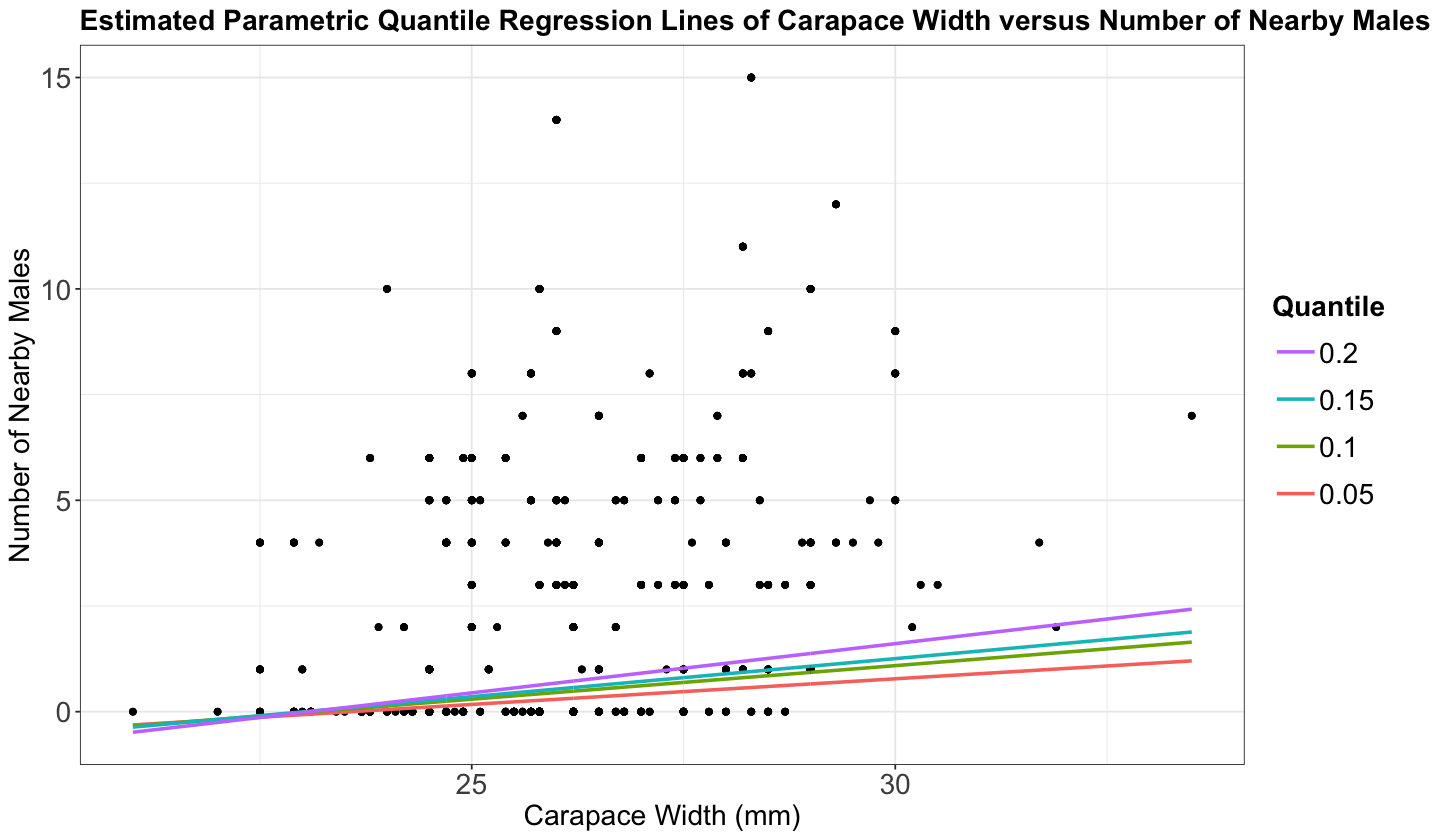

In [40]:
p_crabs_dither 

We now have distinct lines for the low quantiles.

```{admonition} Why was not this a big problem with the previous baseball-related dataset?
Because, given the size of the counts of around 400 to 800 in dataset `teams`, the points "behave similarly" to continuous data. However, we still could (and should!) use the `dither()` function in the `teams` model, but the results should be fairly similar (compare the output below with the one you obtained at the beginning with `teams`).
```

Let us refit our parametric Quantile regressions with `tau = c(0.25, 0.5, 0.75)` in dataset `teams` using `dither()` .

In [41]:
fit_rq_teams_dither_final <- rq(dither(runs, type = "right", value = 1) ~ hits, data = teams, tau = c(0.25, 0.5, 0.75))

set.seed(562)
# We use 1000 bootstrapping replicates as before in teams.
summary(fit_rq_teams_dither_final, se = "boot", bsmethod = "xy", R = 1000)


Call: rq(formula = dither(runs, type = "right", value = 1) ~ hits, 
    tau = c(0.25, 0.5, 0.75), data = teams)

tau: [1] 0.25

Coefficients:
            Value     Std. Error t value   Pr(>|t|) 
(Intercept) -63.57040  22.43262   -2.83384   0.00463
hits          0.51575   0.01608   32.07123   0.00000

Call: rq(formula = dither(runs, type = "right", value = 1) ~ hits, 
    tau = c(0.25, 0.5, 0.75), data = teams)

tau: [1] 0.5

Coefficients:
            Value    Std. Error t value  Pr(>|t|)
(Intercept) 19.80434  7.59960    2.60597  0.00921
hits         0.48741  0.00582   83.70452  0.00000

Call: rq(formula = dither(runs, type = "right", value = 1) ~ hits, 
    tau = c(0.25, 0.5, 0.75), data = teams)

tau: [1] 0.75

Coefficients:
            Value    Std. Error t value  Pr(>|t|)
(Intercept) 58.72075 10.47109    5.60789  0.00000
hits         0.49816  0.00756   65.86315  0.00000

Then, if we compare them to our initial models, we can see that our modelling summaries are similar.

In [42]:
set.seed(562)
# We use 1000 bootstrapping replicates as before in teams.
summary(fit_rq_teams, se = "boot", bsmethod = "xy", R = 1000)


Call: rq(formula = runs ~ hits, tau = c(0.25, 0.5, 0.75), data = teams)

tau: [1] 0.25

Coefficients:
            Value     Std. Error t value   Pr(>|t|) 
(Intercept) -63.63585  22.64757   -2.80983   0.00499
hits          0.51541   0.01623   31.74914   0.00000

Call: rq(formula = runs ~ hits, tau = c(0.25, 0.5, 0.75), data = teams)

tau: [1] 0.5

Coefficients:
            Value    Std. Error t value  Pr(>|t|)
(Intercept) 19.19713  7.70558    2.49133  0.01278
hits         0.48746  0.00588   82.97028  0.00000

Call: rq(formula = runs ~ hits, tau = c(0.25, 0.5, 0.75), data = teams)

tau: [1] 0.75

Coefficients:
            Value    Std. Error t value  Pr(>|t|)
(Intercept) 58.56682 10.43408    5.61303  0.00000
hits         0.49770  0.00753   66.06291  0.00000

## 6. Wrapping Up

- We can extend the regression paradigm beyond the conditioned response mean.
- We could assess association (or causation under a proper experimental framework!) via different response statistics such as quantiles to a set of regressors.
- Quantile regression can be non-parametric (more suitable for predictions) or parametric (to allow for coefficient interpretation).